# 0.0  IMPORTS

In [3]:
import math
import datetime
import inflection
import numpy   as np
import pandas  as pd
import seaborn as sns
import xgboost as xgb
import random
import pickle
import warnings


from tabulate             import tabulate
#from pandas               import MultiIndex, Int16Dtype
from IPython.core.display import HTML
from IPython.display      import Image
from matplotlib           import gridspec
from scipy                import stats as ss
from boruta               import BorutaPy
from matplotlib           import pyplot as plt

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso

warnings.filterwarnings( 'ignore' )

## 0.1.  Helper Functions

In [4]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    #pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
def cramer_v (x,y): #FUNÇÃO PARA CALCULO DE CRAMER.V - ANALISE MULTIVARIADA
    cm = pd.crosstab (x, y).values
    n = cm.sum() #soma de todos os valores da matriz
    r, k =cm.shape #número de linhas e colunas
    
    chi2 = ss.chi2_contingency(cm) [0] #método pronto para calculo de chi2 (precisa de uma tabela de contingencia (CM) para o calculo) / biblioteca scipy
    chi2corr = max(0 , chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
        
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)))




def ml_error ( model_name, y, yhat): #função recebe nome do modelo, y real e o y estimado
    mae = mean_absolute_error (y, yhat)
    mape = mean_absolute_percentage_error (y, yhat)
    rmse = np.sqrt(mean_squared_error (y,yhat))
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )


def cross_validation (x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range ( 1, kfold+1 )): #percorre o dataset com o k tendo valor da range invertida
        if verbose:
            print( '\nKFold Number: {}'.format( k ))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7) #identifica a data inicial do dataset de validação
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7) #identifica a data final do dataset de validação

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date] # define o dataset de treino 
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)] # define o df de validação

        # training and validation dataset (sem o 'date' e 'sales')
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat))

        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    # Cria Dataframe com a media e desvio padrão do MAE, MAPE e RMSE (para o cross-validation)
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str) }, index=[0] )




In [5]:
jupyter_settings()

## 0.2. Loading Data

In [6]:
df_store_raw = pd.read_csv('dataset/store.csv', low_memory=False)
df_sales_raw = pd.read_csv('dataset/train.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store' )
df_raw

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [7]:
df1 = df_raw.copy()

# 1.0 PASSO 01: DESCRIÇÃO DOS DADOS

## 1.1. Rename Columns

In [8]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

#define a função para transformar as strings
lower_ = lambda x: x.lower() #transforma em letras minusculas
snakecase = lambda x: inflection.underscore(x) #transforma em letra minuscula com separação por underscore


#define a variavel, com a lista da aplicação da função map
new_cols = list (map(snakecase,old_cols))

#RENAME - substitui o nome das colunas pela new_cols
df1.columns = new_cols

## 1.2. Data Dimensions 


In [9]:
# descreve a dimensão do Dataset, com a função format.
# a função shape, printa a quantidade de [linhas, colunas], por isso shape[0] e shape[1]
print ('Number of Rows: {}'.format (df1.shape[0]))
print ('Number of Columns: {}'.format (df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types 


In [10]:
# converte a coluna date para formato datetime
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA 


In [11]:
# verifica a somatória de NA existente em cada coluna
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA 


In [12]:
# o tratamento de NA's pode ser feita de 3 maneiras:
#  - com a exclusão das linhas (que pode impactar nas informações)
#  - com algoritmo para fazer o preenchimento (atraves do comportamento da coluna)
#  - com a lógica de negócio (caso tenha alguma regra específica)

In [13]:
df1['competition_distance'].max()

75860.0

In [14]:
# competition_distance - assumindo que a próxima farmácia é muito distante e não tem competição, então será substituido por um valor muito maior que o valor maximo apresentado.

df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month - assumindo a data de venda  

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'])                                                   else x['competition_open_since_month'], axis=1)
                                          
# competition_open_since_year - assumindo a data de venda      

df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else                                                      x['competition_open_since_year'], axis=1)

# promo2_since_week  

df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else                                                           x['promo2_since_week'], axis=1)


# promo2_since_year  

df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else                                                           x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan',  2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sept',  10: 'Oct', 11: 'Nov', 12: 'Dec'} # cria dicionário para substituir o numero do mês

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types


In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype ('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype ('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype ('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype ('int64')

## 1.7. Descriptive Statistical 


In [17]:
#tendencia Central - mean, median
#dispersão - std, min, max, range, skew, kurtosis

#precisa separar variaveis numéricas e categoricas

In [18]:
num_attributes = df1.select_dtypes(include = ('int64', 'float64'))
cat_attributes = df1.select_dtypes(exclude = ('int64', 'float64', 'datetime64[ns]'))

### 1.7.1. Numerical Attributes

In [19]:
#tendencia Central - mean, median
ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T

#dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.min()).T
d3 = pd.DataFrame( num_attributes.max()).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

#Concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [20]:
#👍 MESMA COISA DE FORMA DIFERENTE
#O pandas tem uma função que faz o agregado de métricas do dataframe chamada agg.
#Pra incluir o 'range', podemos utilizar a função 'ptp' (Peak-to-PeaK)

#num_attributes.agg(['min', 'max', 'ptp', 'mean', 'median', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'attributes', 'ptp': 'range'})👍

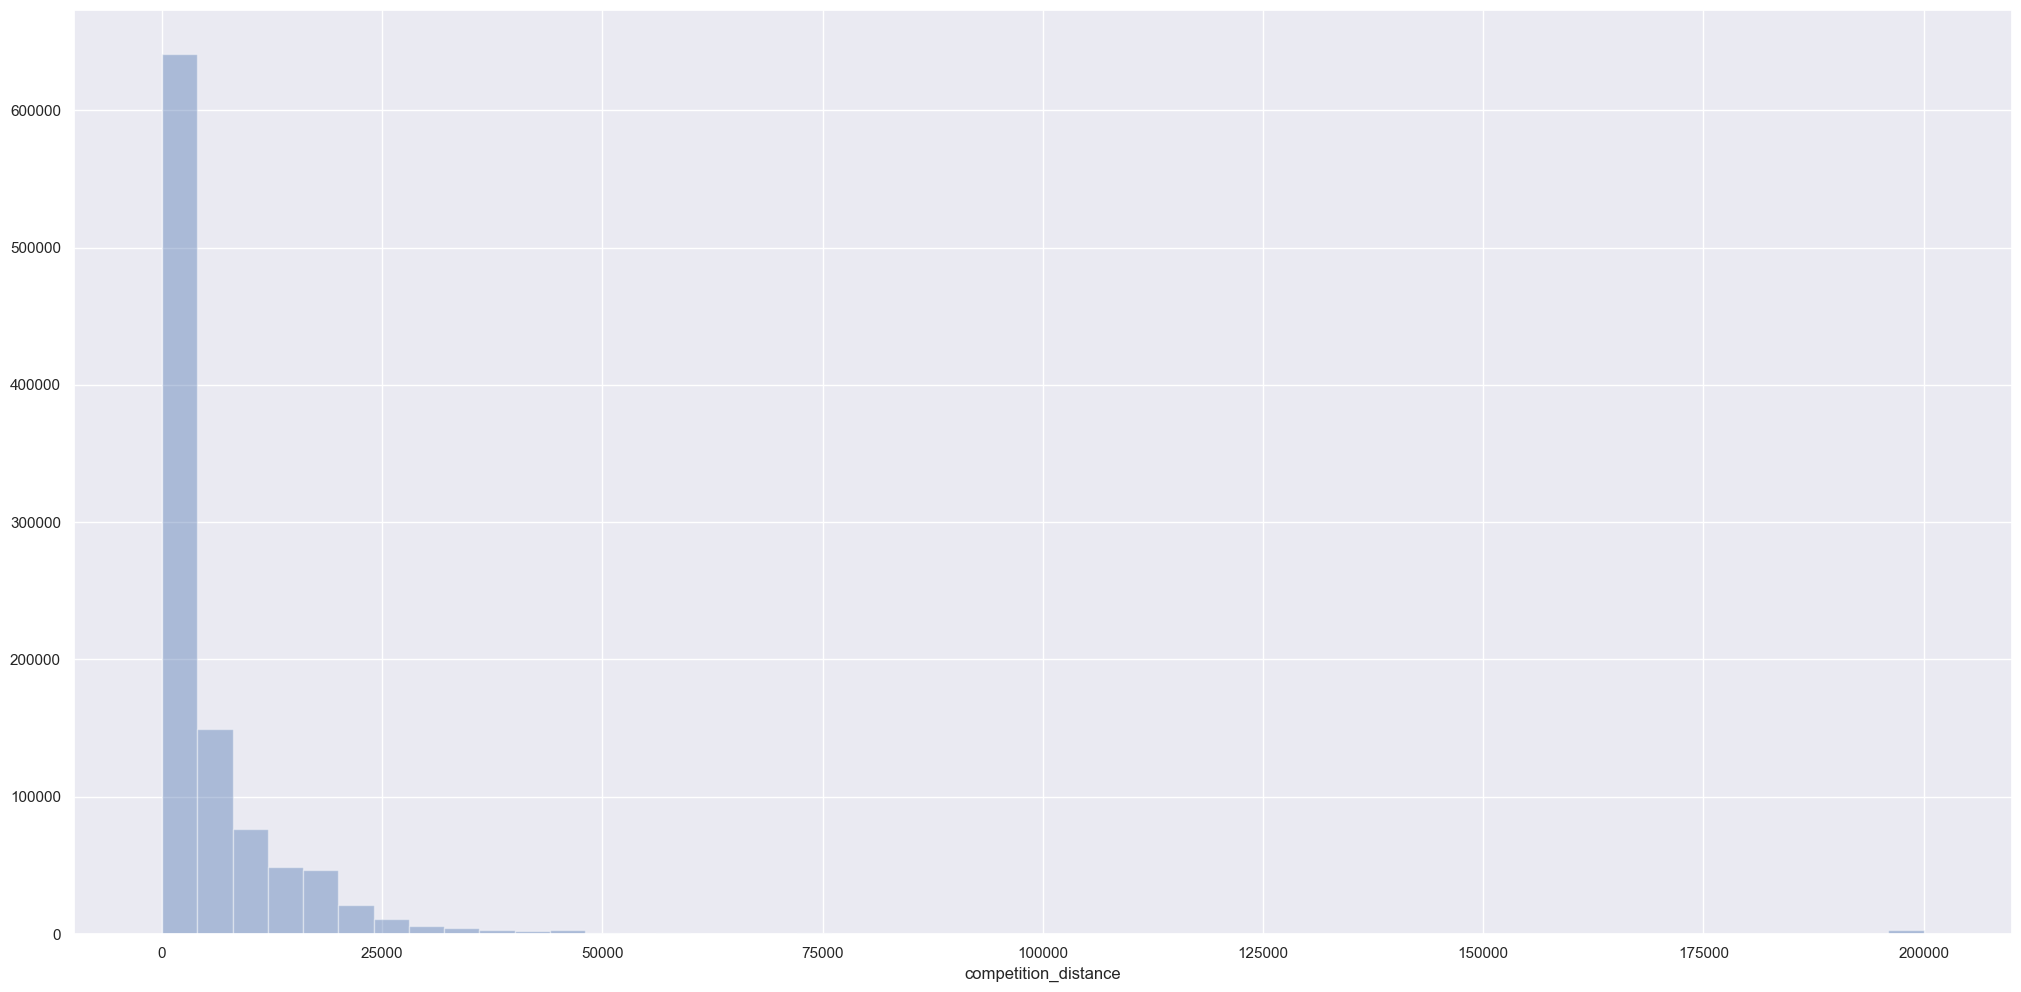

In [21]:
#verifica graficamente a distribuição das variaveis de determinada coluna
sns.distplot( df1['competition_distance'], kde=False );

### 1.7.2. Categorial Attributes

In [22]:
#para identificar a quantidade de variaveis
cat_attributes.apply( lambda x: x.unique().shape[0] )


state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

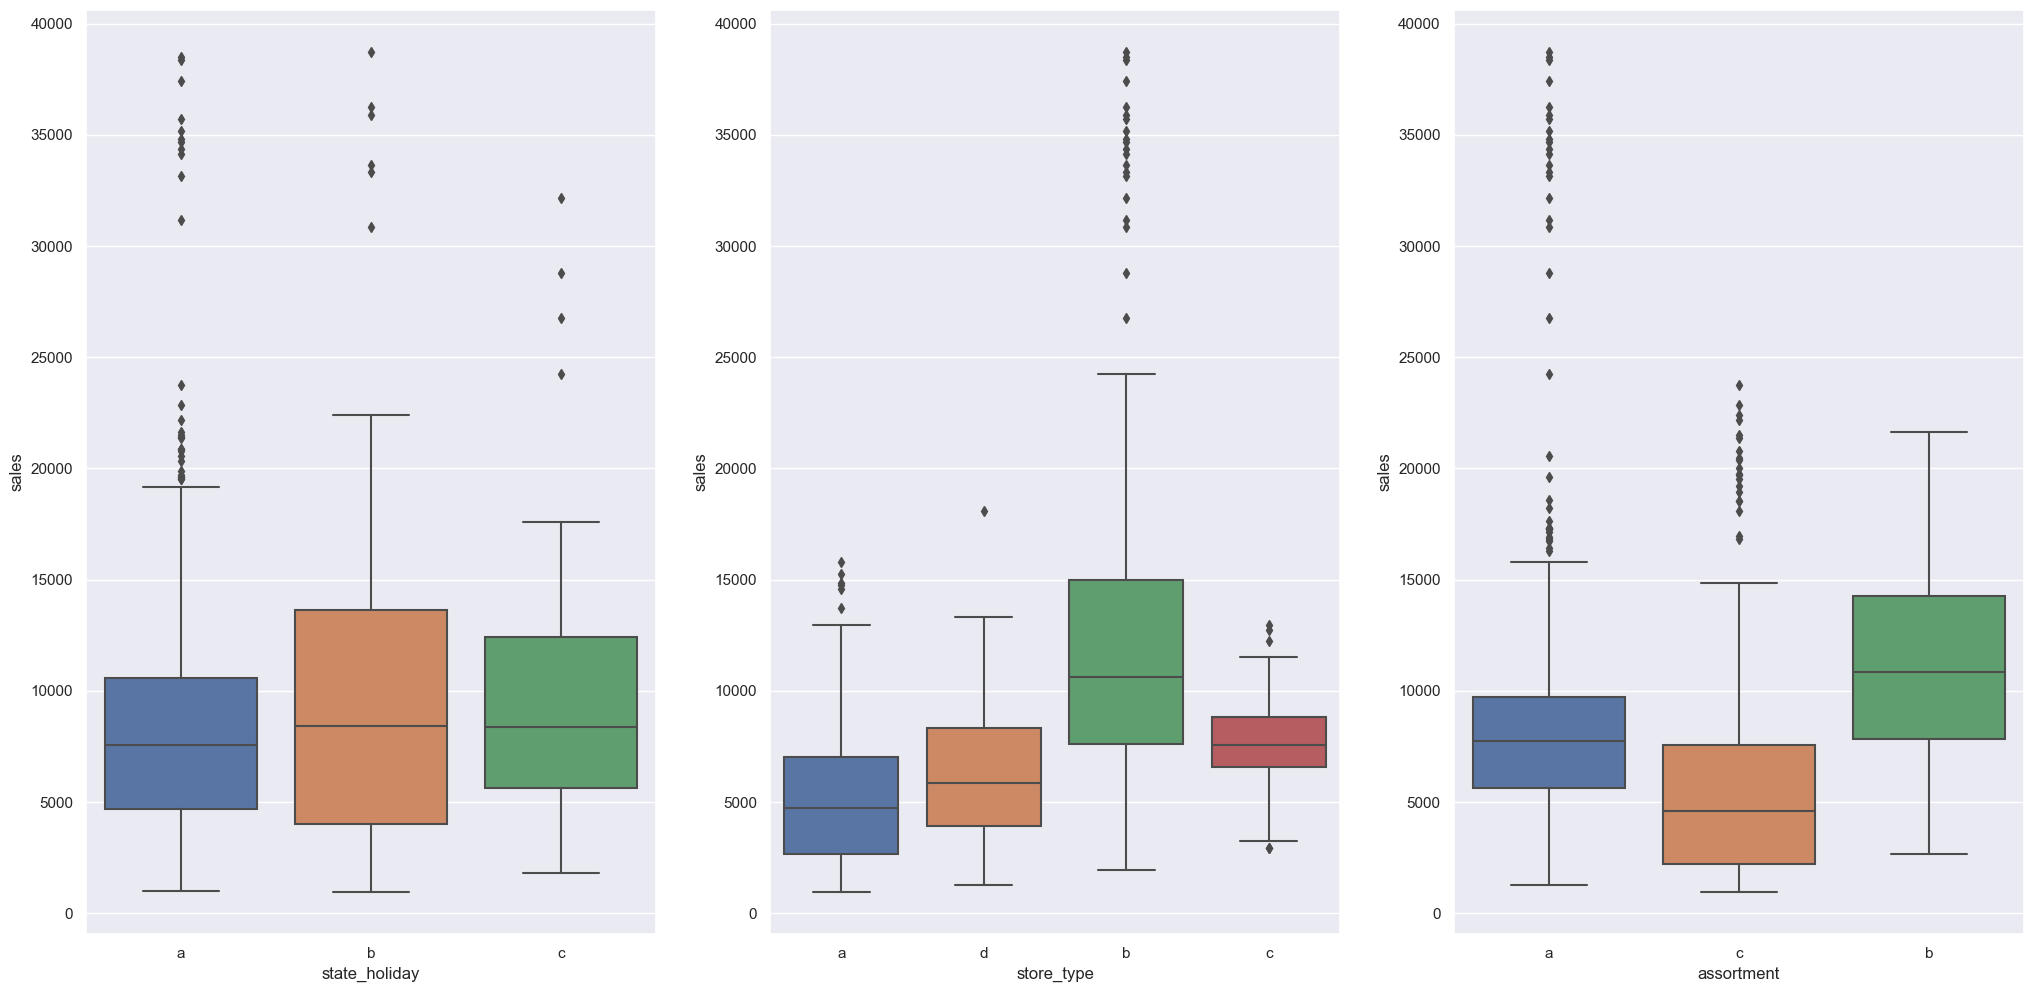

In [23]:
#cria variavel auxiliar para retirar valores = 0
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
aux1 = df1[df1['sales'] > 0]

#para colocar os graficos lado a lado (plt.subplot( linhas, colunas, posição)).
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux );

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux );

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux );



# 2.0 PASSO 02: FEATURE ENGINEERING 


In [24]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipótese

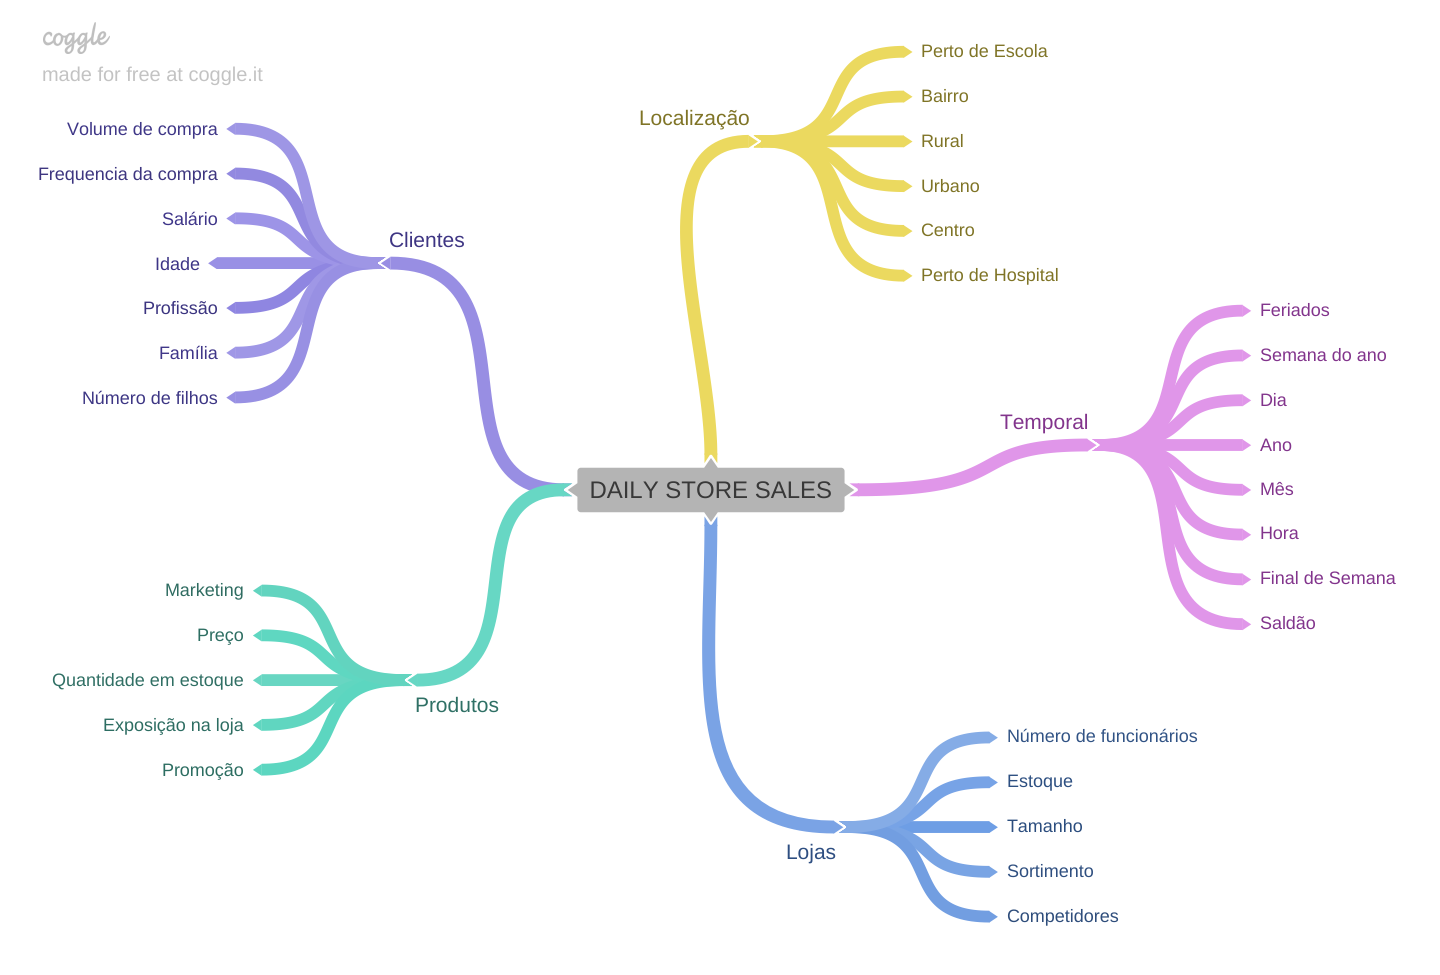

In [25]:
# usando a classe image para importar o mapa mental
Image('MindMapHypotesis.png')

## 2.2. Criação de Hipóteses

### 2.2.1. Hipóteses Loja


**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipóteses Produto


**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [26]:
# year (coluna, transforma em datatime (dt) e usa o metodo .year)
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
df2['week_of_year'] = df2['week_of_year'].astype('int64')

# year week
df2['year_week'] = df2['date'].dt.strftime ('%Y-%W')

#competition since
#cria coluna competition_since, fazendo a união atravez do método datetime.datetime
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
#faz a diferença das colunas date e competition_since - para obter o tempo de promoção em mes
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
df2['competition_time_month'] = df2['competition_time_month'].astype('int64')


# promo since
#faz a conversão em str, e a união das colunas promo2_since_year e promo_since_week, para formação da coluna promo_since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
#faz a formatação e granularidade da coluna
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' )-datetime.timedelta( days=7 ) )
#faz a diferença 
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )
df2['promo_time_week'] = df2['promo_time_week'].astype('int64')



# assortment 
#faz a substituição das letras pelo seu significado
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
#faz a substituição pelos significados
df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


In [27]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03: FILTRAGEM DE VARIÁVEIS

In [28]:
df3 = df2.copy()

In [29]:
df3.apply(lambda x: x.unique().shape[0])

store                            1115
day_of_week                         7
date                              942
sales                           21734
customers                        4086
open                                2
promo                               2
state_holiday                       4
school_holiday                      2
store_type                          4
assortment                          3
competition_distance              655
competition_open_since_month       12
competition_open_since_year        23
promo2                              2
promo2_since_week                  52
promo2_since_year                   7
promo_interval                      4
month_map                          12
is_promo                            2
year                                3
month                              12
day                                31
week_of_year                       52
year_week                         137
competition_since                 173
competition_

## 3.1. Filtragem das Linhas

In [30]:
#seleciona as linhas diferentes de 0 na coluna open e as maiores que zero na coluna sales, e sobescreve o df3
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [31]:
#seleciona somente as colunas relevantes para o modelo

In [32]:
#define as colunas 'irrelevantes' para o modelo, neste momento. (Customers não estará disponível no momento da aplicação do modelo.)
cols = ['customers' , 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols, axis=1)

# 4.0. PASSO 04: ANÁLISE EXPLORATÓRIA DE DADOS


In [33]:
df4 = df3.copy()

In [34]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [35]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 4.1. Análise Univariada

### 4.1.1. Response Variable

In [36]:
# cria um grafico de distribuição da variavel resposta (vendas)
# algoritimos de ML são criado baseados em algumas premissas de comportamento dos dados (que o dado seja independente e que sejam normalmente distribuidos.)
#é possivel fazer transformações para que fique mais proximo da normal (central)

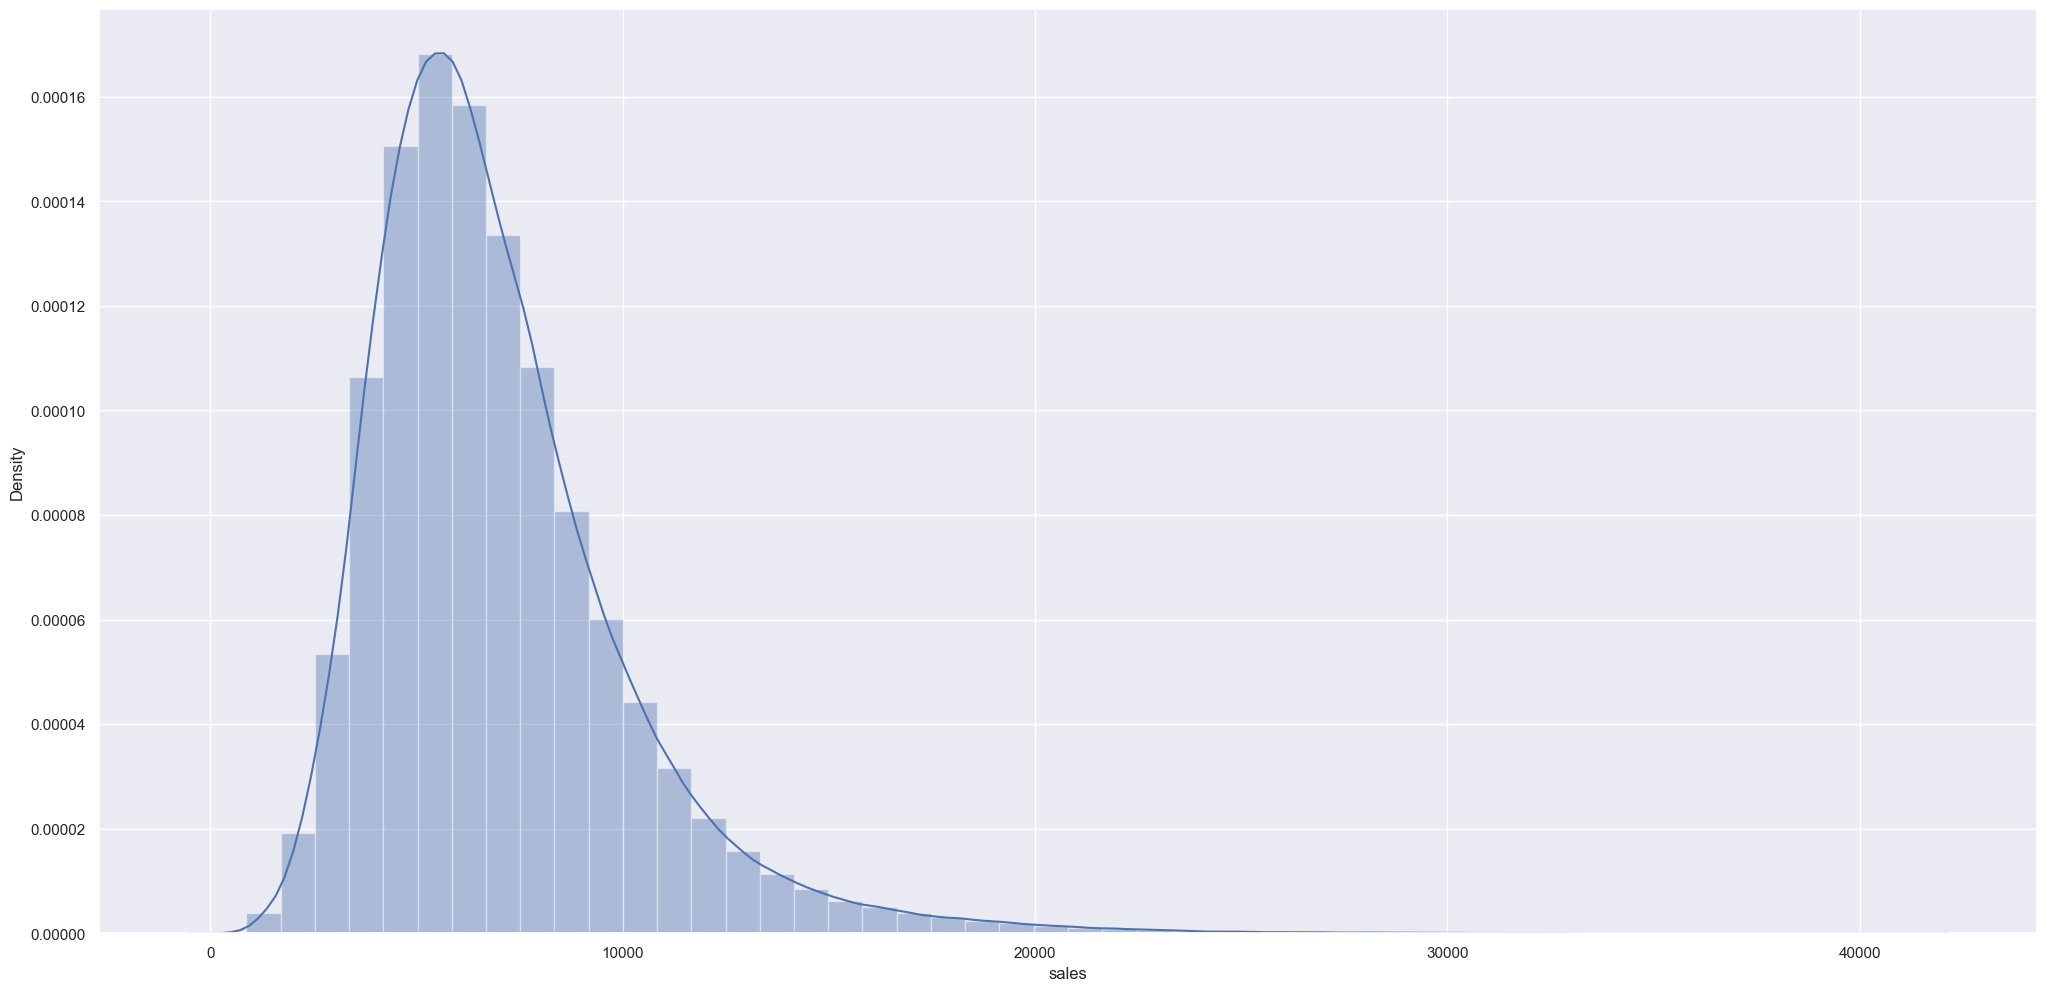

In [37]:
sns.distplot(df4['sales']);

### 4.1.2. Numerical Variable

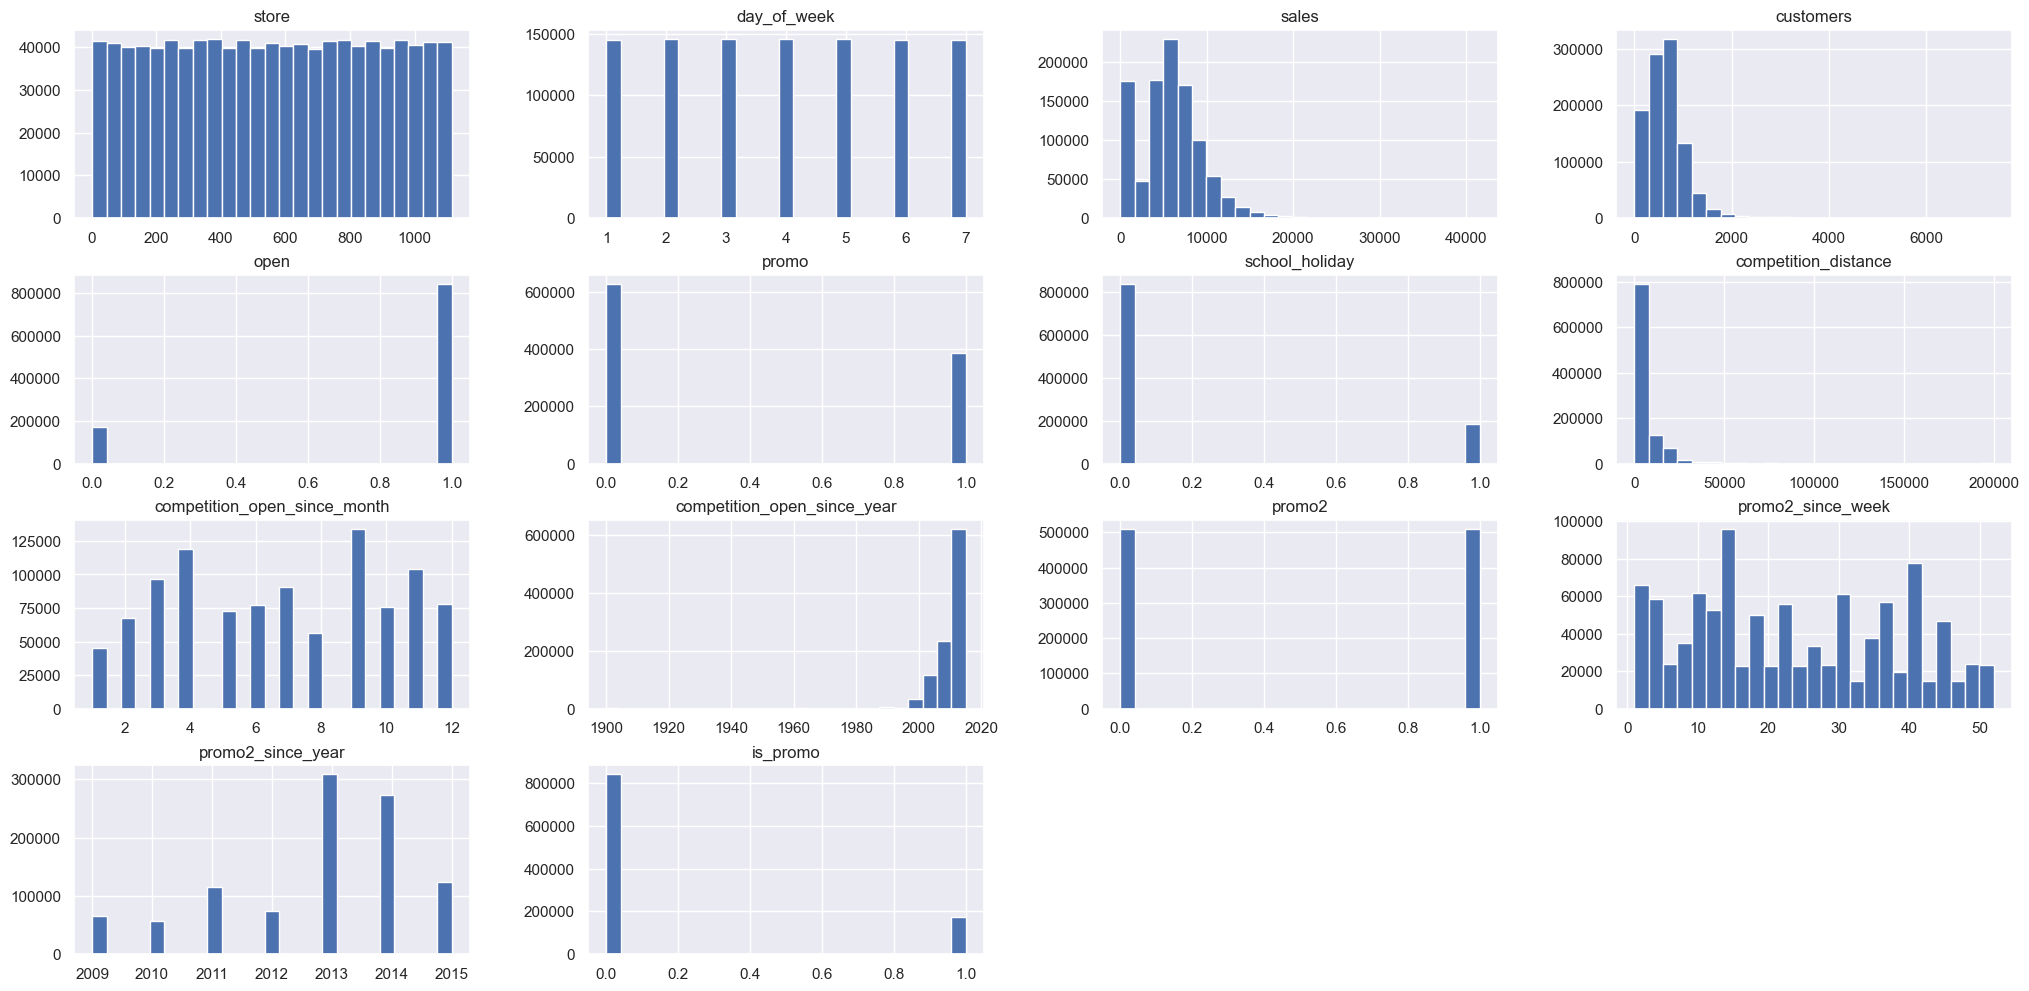

In [38]:
# descreve o comportamento da variável. Quanto mais comportamento a variavel tem, mais explicativa ela é sozinha.

num_attributes.hist( bins=25);


### 4.1.3. Categorical Variable

In [39]:
#para verificar quais as variáveis.
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [40]:
#para identificar os tipos de state_holiday
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [41]:
#para identificar os tipos de store_type
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [42]:
#para identificar os tipos de assortment
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

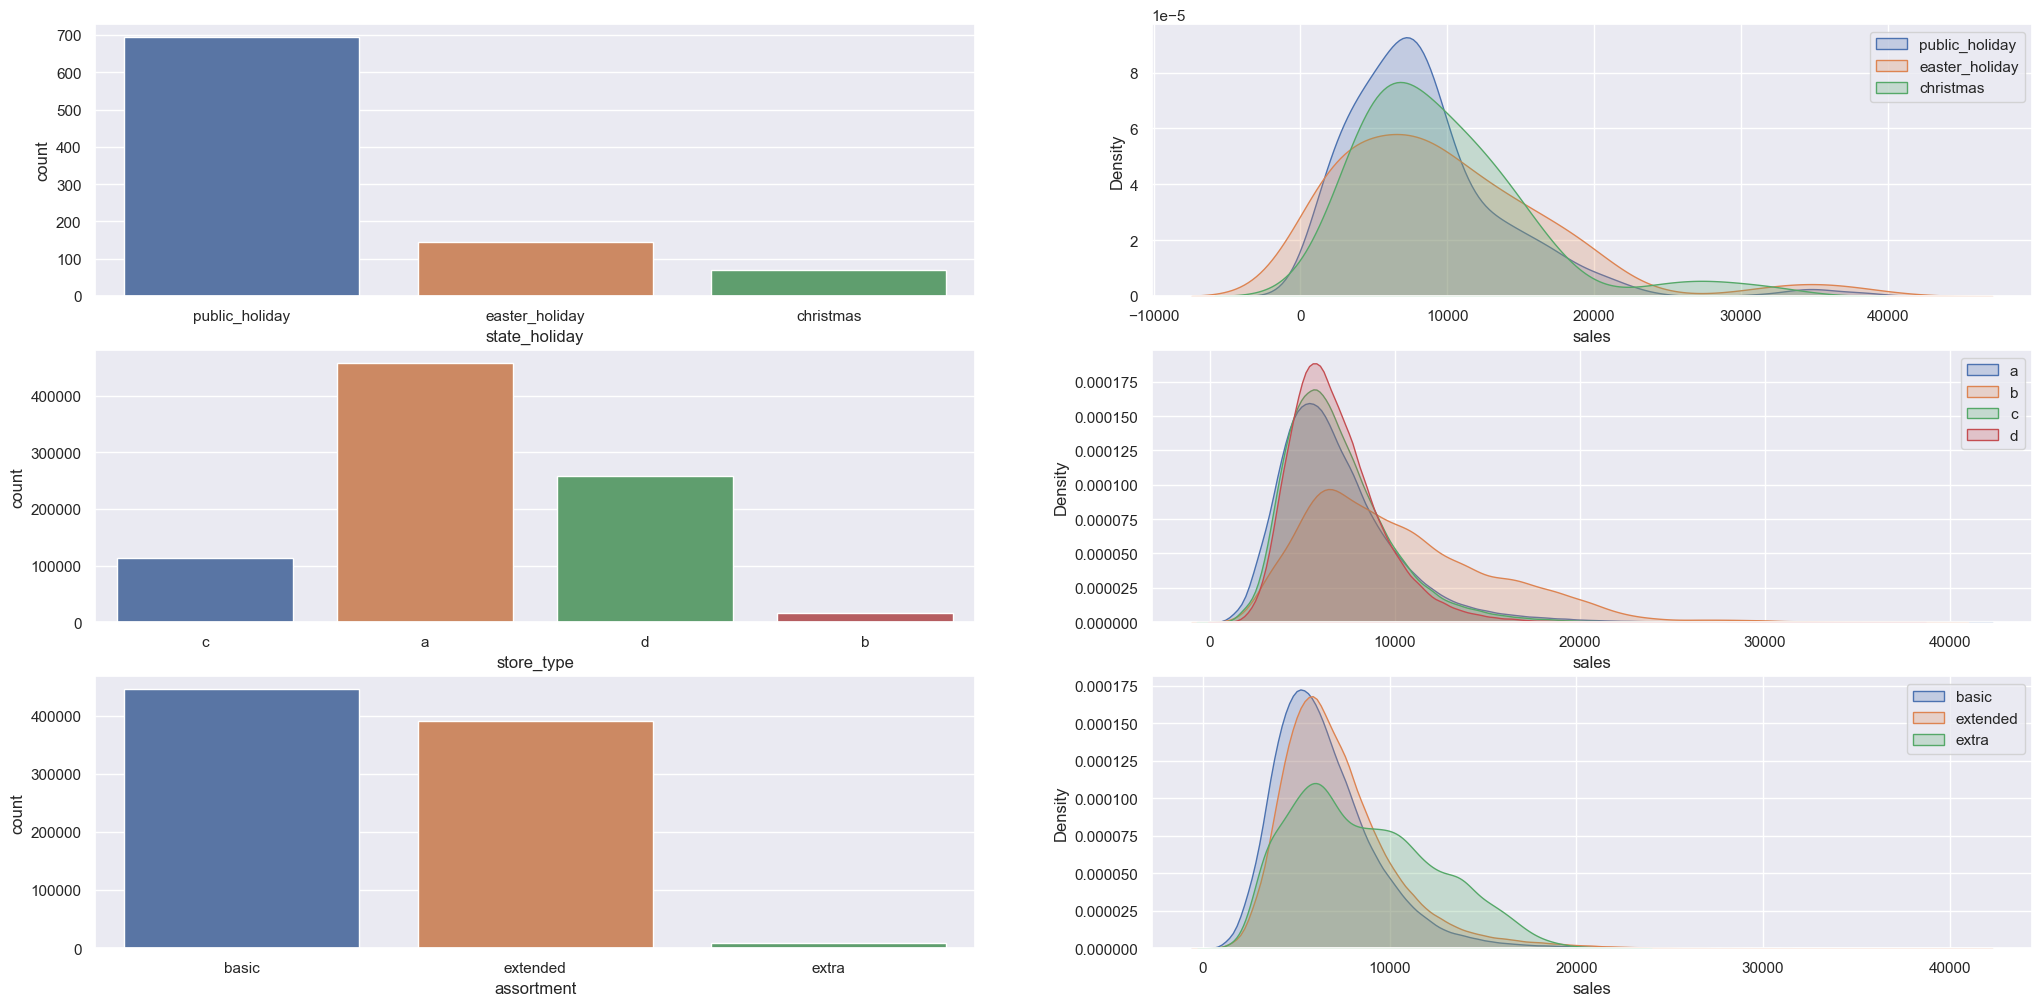

In [43]:
#state_holiday - é preciso filtrar a coluna, excluindo o regular_day, por ser muito grande não permite a visualização dos outros.
#filtragem
plt.subplot (3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot (3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend();
#sns.kdeplot(data=a , x='sales', hue='state_holiday', fill=True, common_norm=False )

#store_type
plt.subplot (3,2,3)
sns.countplot(df4['store_type']);

plt.subplot (3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend();
#sns.kdeplot(data=df4 , x='sales', hue='store_type',  fill=True, common_norm=False )

#assortment
plt.subplot (3,2,5)
sns.countplot(df4['assortment']);

plt.subplot (3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend();
#sns.kdeplot(data=df4 , x='sales', hue='assortment', fill=True, common_norm=False )

#===========================================================
## 💡💡💡💡ESTUDAR INTERPRETAÇÃO DISTRIBUIÇÕES 💡💡💡💡
#===========================================================

## 4.2. Análise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.

**FALSA** Lojas com maior sortimento vendem menos

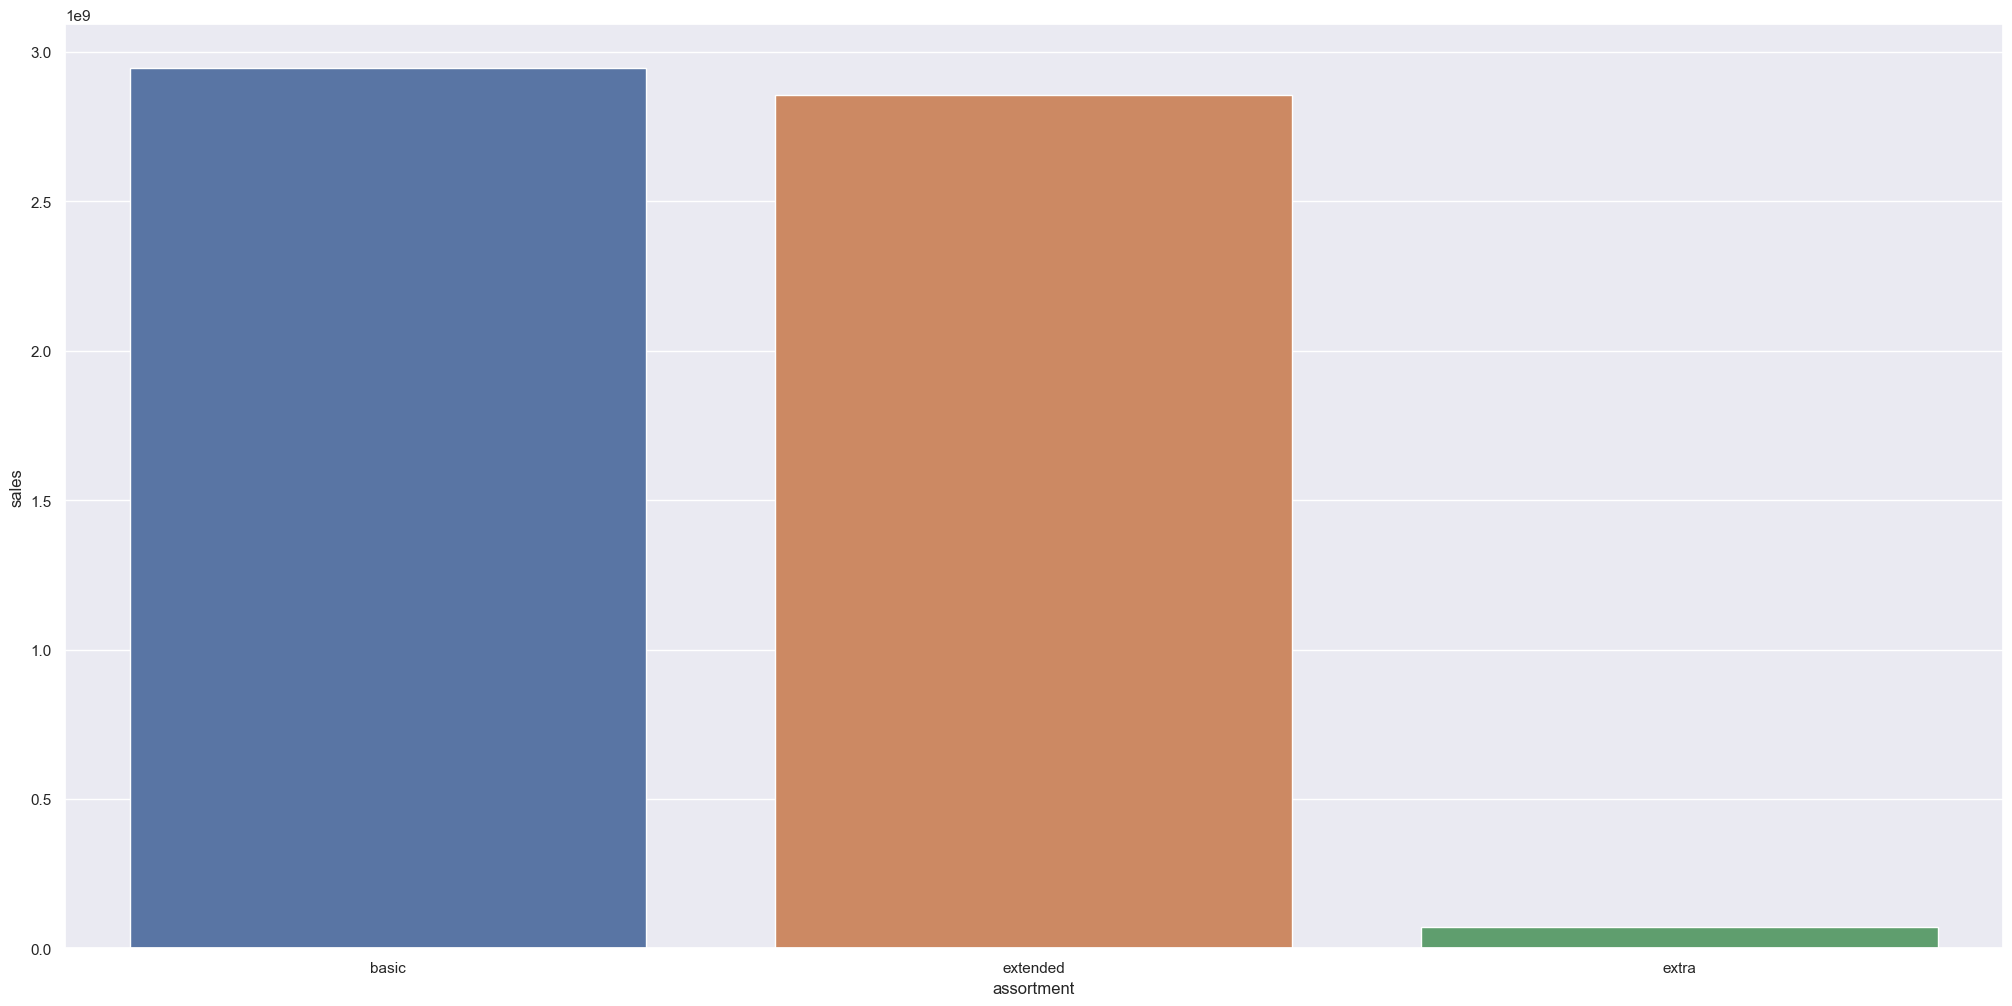

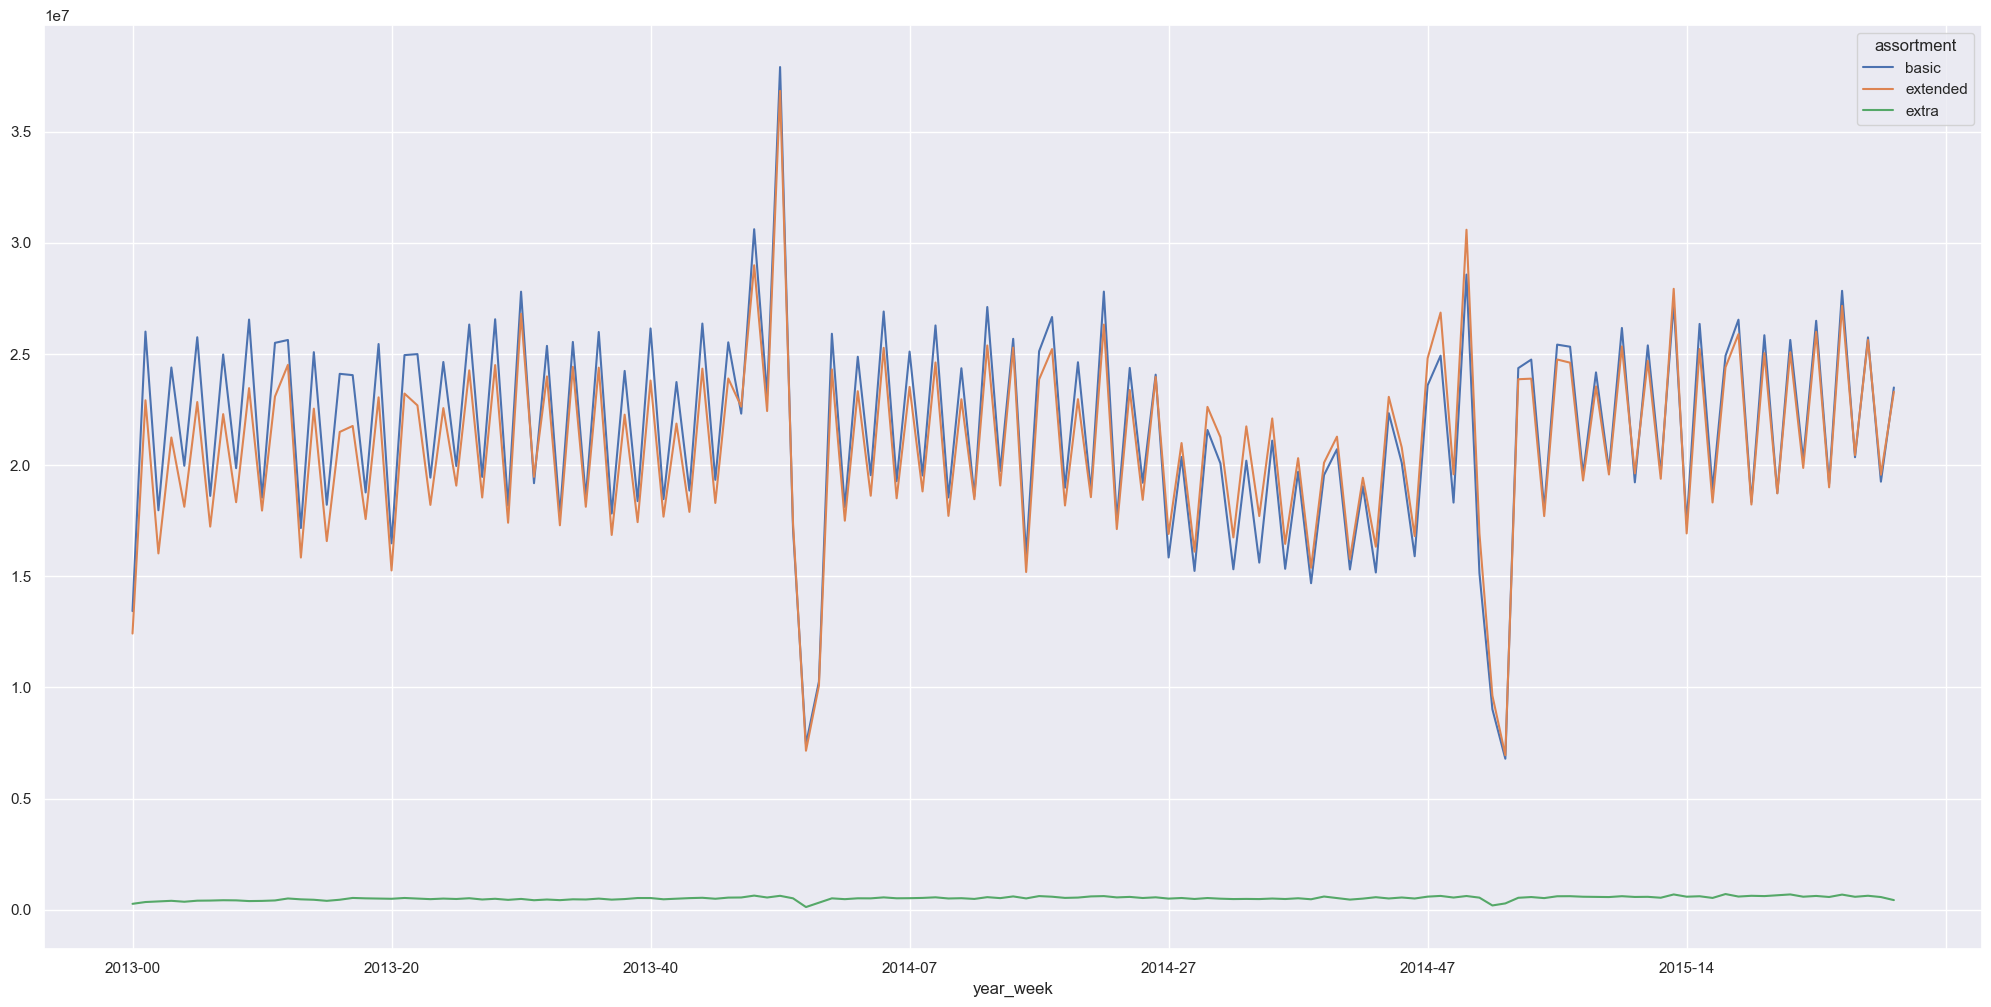

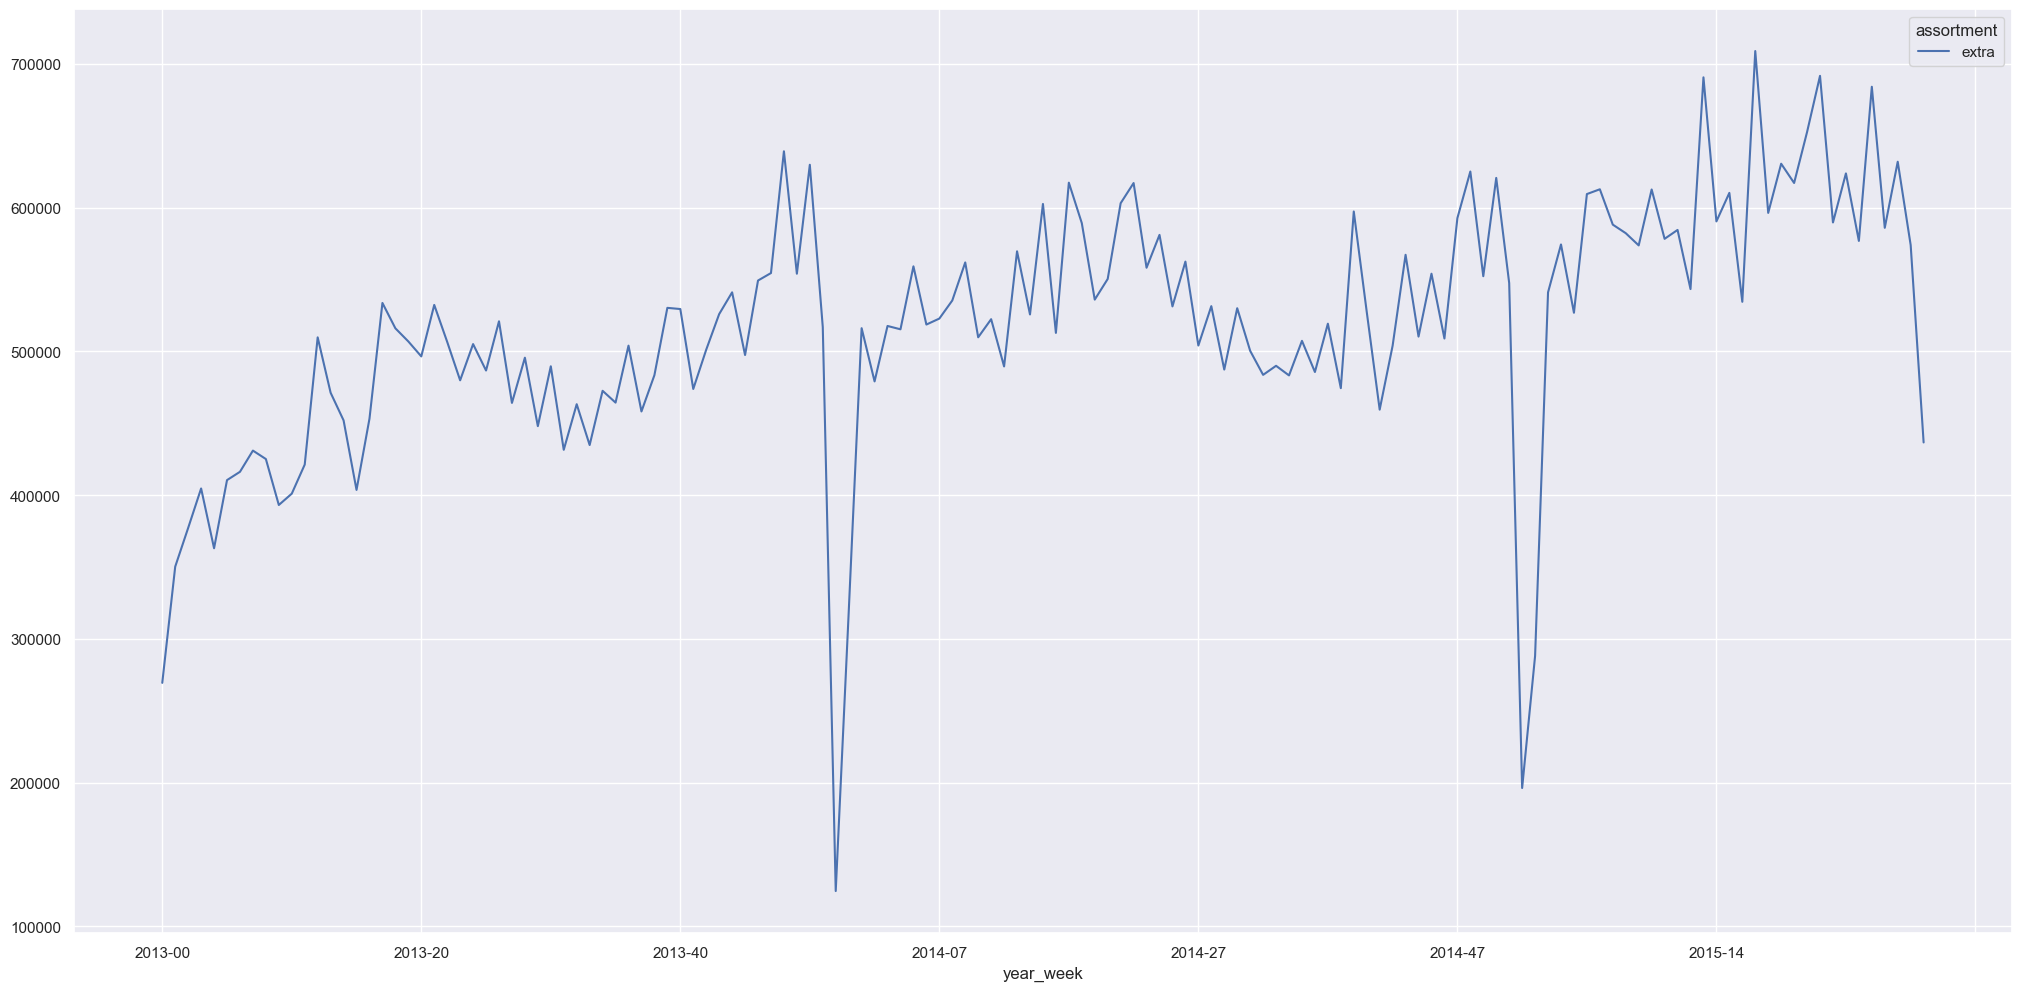

In [44]:
aux1 = df4[['assortment', 'sales']].groupby ('assortment').sum().reset_index()
sns.barplot(data=aux1, x='assortment', y='sales');

aux2 = df4[['year_week', 'assortment', 'sales']].groupby (['assortment', 'year_week']).sum().reset_index()
#sns.lineplot(data=aux2, x='year_week', y='sales', hue='assortment');
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();


### H2. Lojas com competidores mais próximos deveriam vender menos.

**FALSA** Lojas com competidores mais próximos vendem mais

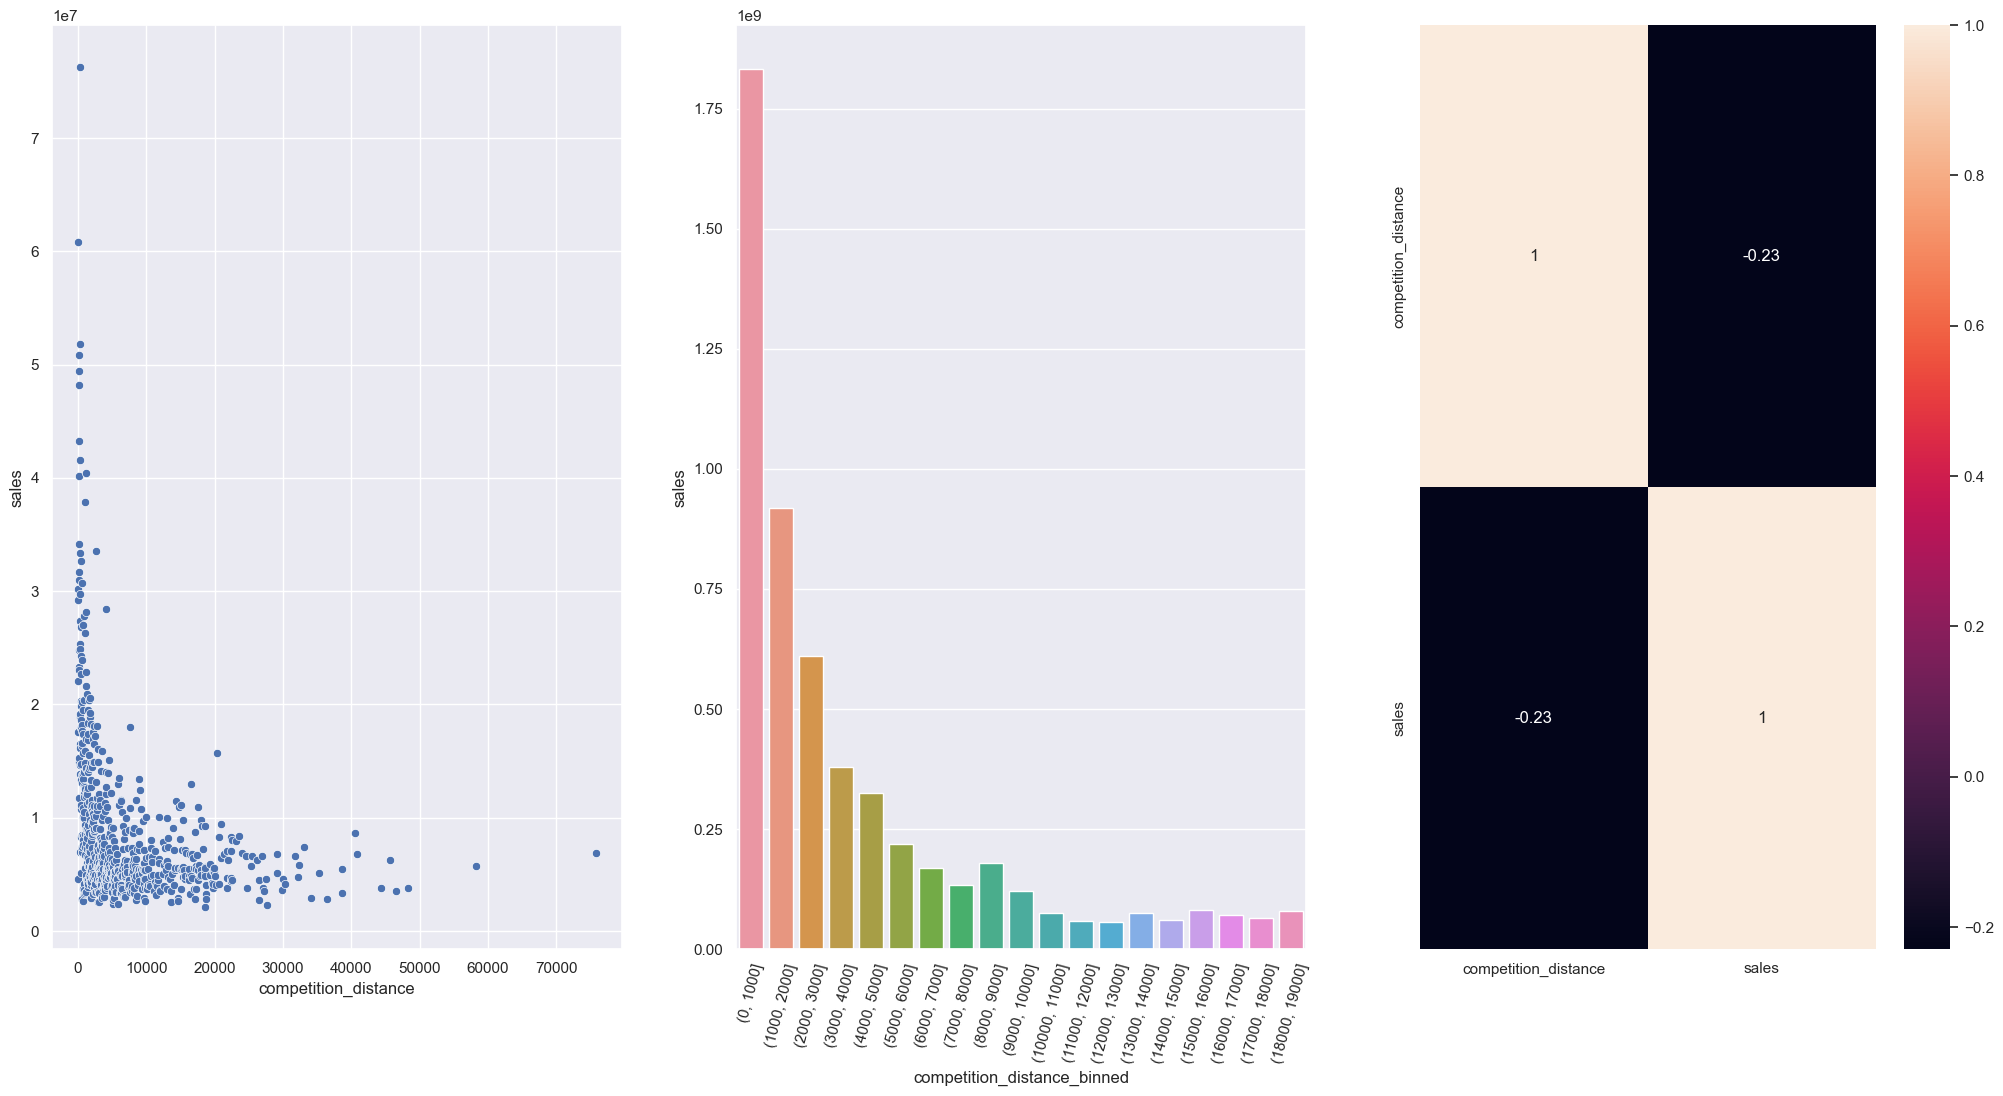

In [45]:
plt.subplot (1,3,1)
a = df4[df4['competition_distance'] != 200000] #filtra distancia != de 200000, uma vez que esse preenchimento foi feito para NA
aux1 = a[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(data = aux1, x='competition_distance', y='sales');

plt.subplot (1,3,2)
bins = list ( np.arange (0,20000,1000)) # faz segmentação num range de 0 a 20000 separando a cada 1000
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins) # cria uma nova coluna (binned), e com o parametro cut, faz a divisão com base na variavel bins
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(data=aux2, x='competition_distance_binned', y='sales');
plt.xticks(rotation=75);

plt.subplot (1,3,3)
aux3=df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.heatmap(aux3.corr(method='pearson'), annot=True);


### H3. Lojas com competidores à mais tempo deveriam vendem mais.

**FALSA** Lojas com competição a mais tempo, vendem menos.

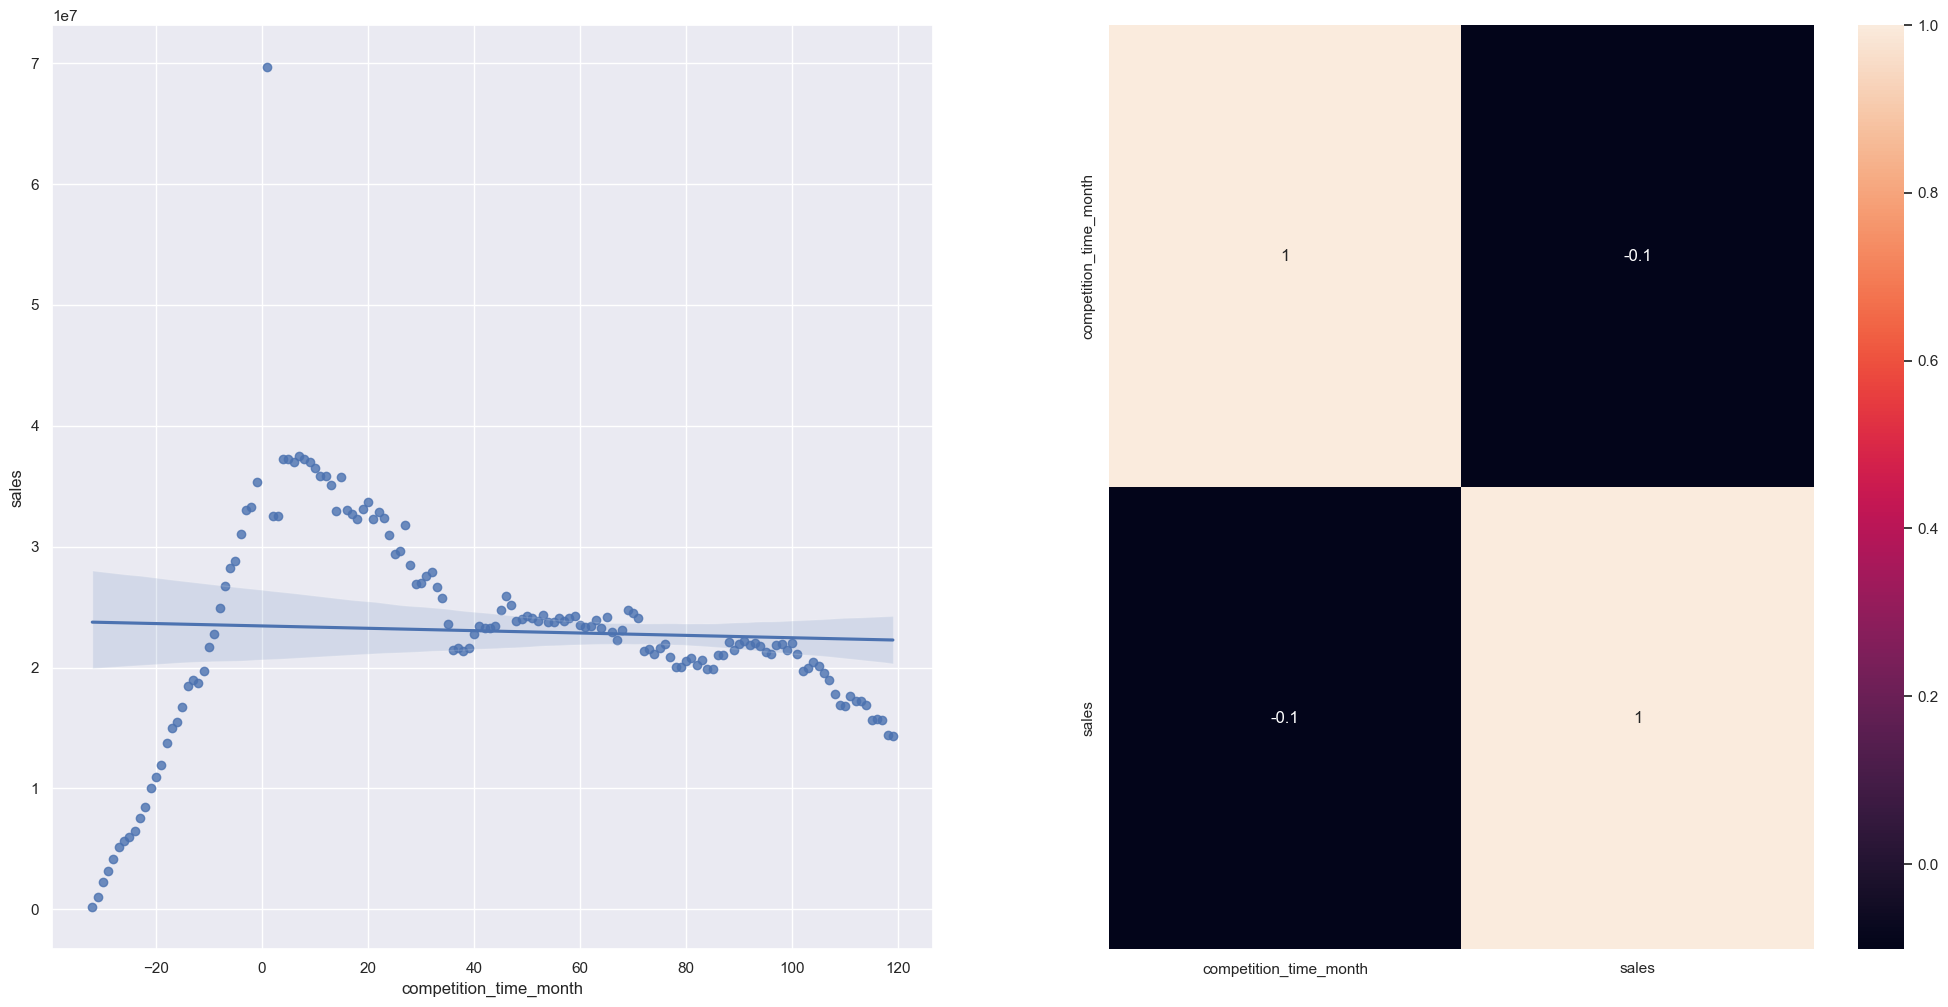

In [46]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

#plt.subplot(1,3,1)
#sns.barplot(data=aux2, x='competition_time_month', y='sales');
#plt.xticks(rotation=75)

plt.subplot(1,2,1)
#sns.scatterplot(data=aux2, x='competition_time_month', y='sales');
sns.regplot( x='competition_time_month', y='sales', data=aux2 ); # opção para gráfico com estimativa de regressão

plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA** Lojas com promo ativas por mais tempo, vendem menos depois de certo período

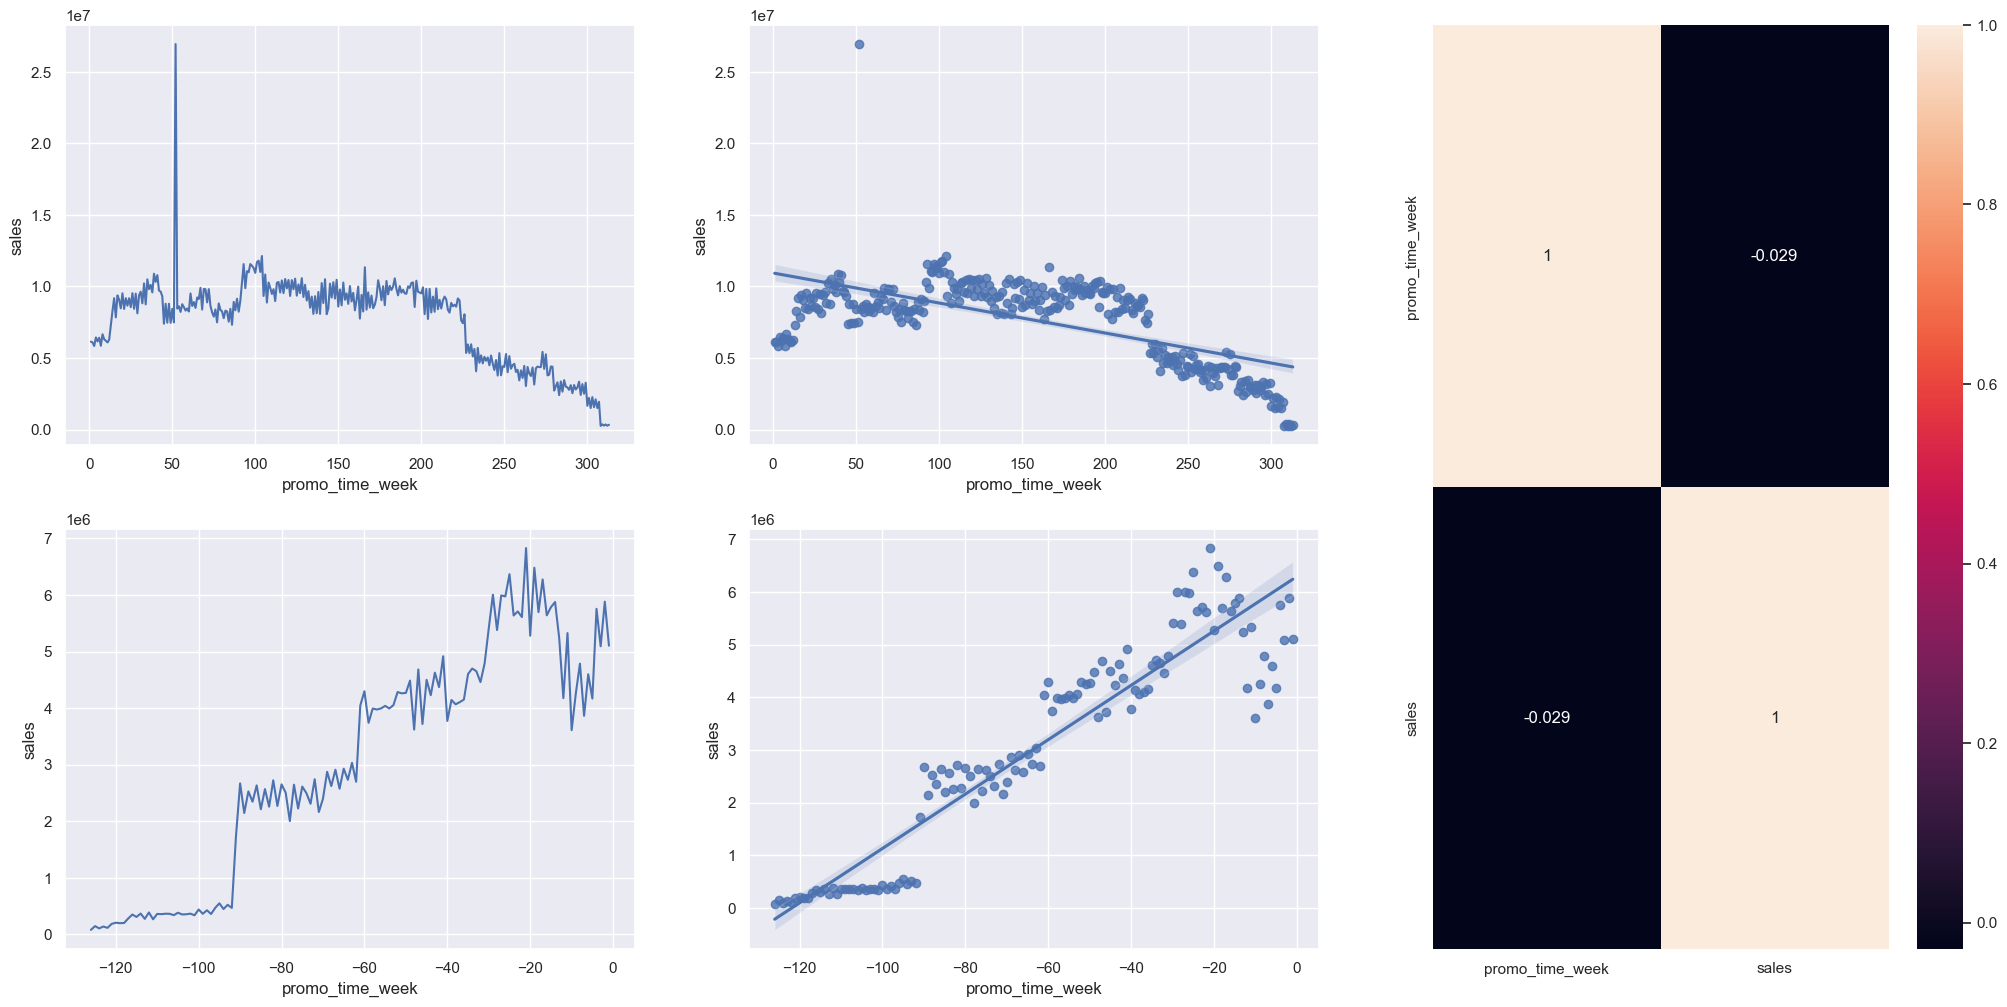

In [47]:
aux1 = df4[['promo_time_week', 'sales']].groupby ('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3) #cria um grid, para poder fazer merge em celulas (tabela 2linhas, 3 colunas)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promoção extendida (promo2)
sns.lineplot(data=aux2, x='promo_time_week', y='sales');

plt.subplot(grid[0,1])
sns.regplot(data=aux2, x='promo_time_week', y='sales'); #tendencia

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promoção tradicional (promo)
sns.lineplot(data=aux3, x='promo_time_week', y='sales');

plt.subplot(grid[1,1])
sns.regplot(data=aux3, x='promo_time_week', y='sales');#tendencia

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True); #correlação

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>



In [48]:
#hipótese similar a H4 - mais detalhada, portanto será deixada para 2 CRISP

### H6. Lojas com mais promoções consecutivas deveriam vender mais.

**FALSA** Lojas com promoções consecutivas vendem menos

In [49]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values('sales', ascending=True)

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


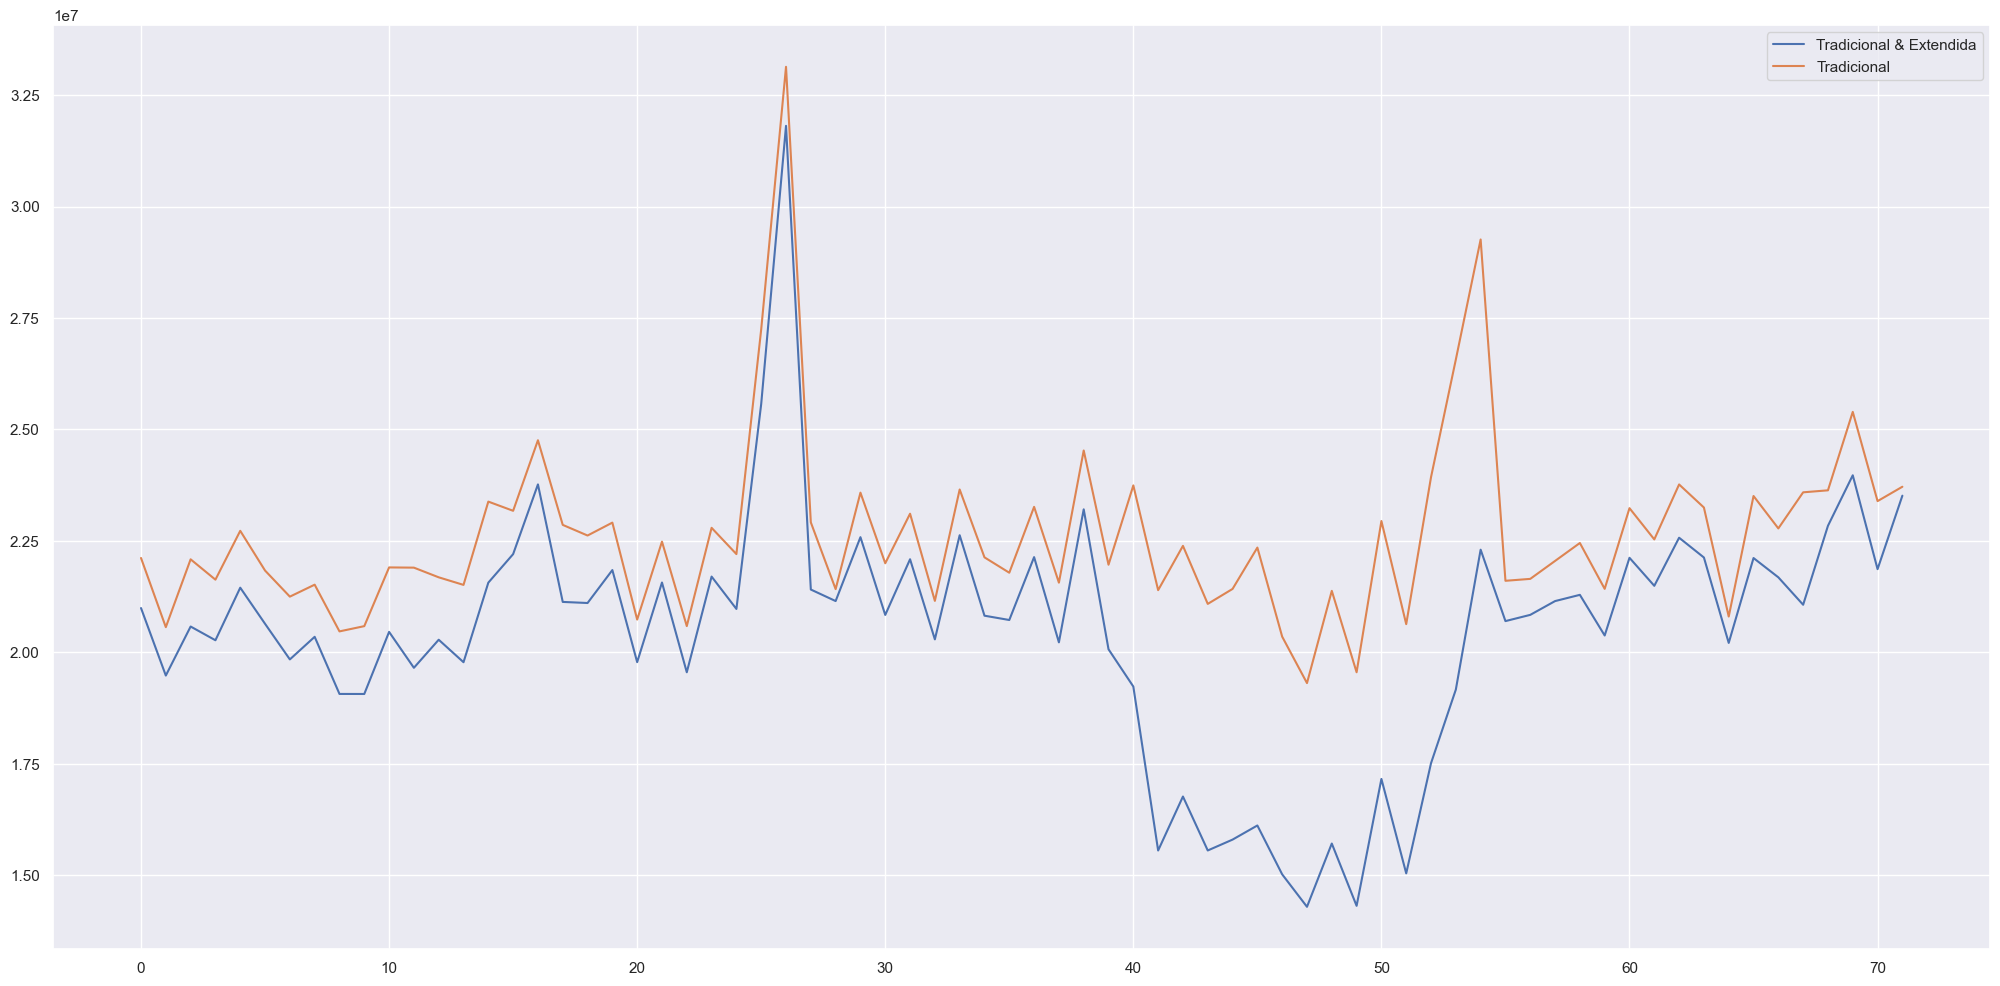

In [50]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend( labels=['Tradicional & Extendida', 'Tradicional'])

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSA** Durante o feriado de Natal as lojas vendem menos

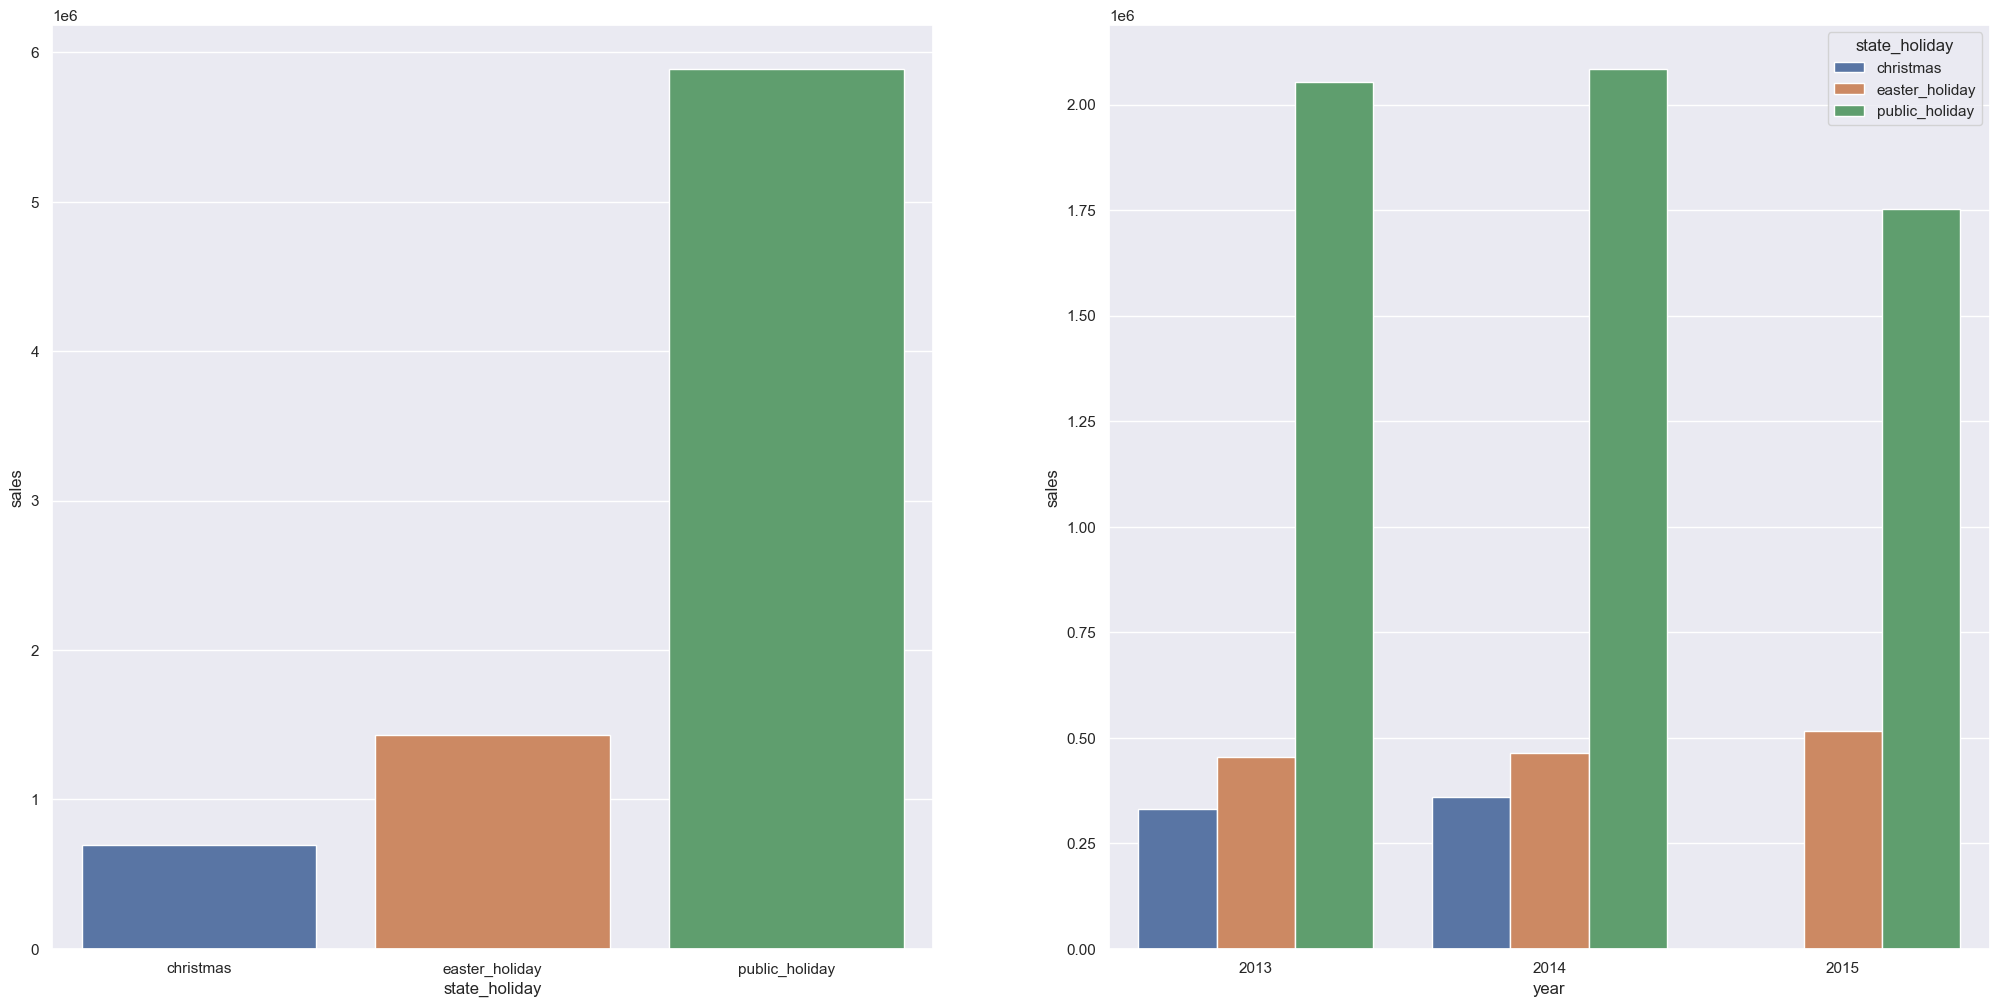

In [51]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data=aux1, x='state_holiday', y='sales');

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(data=aux2, x='year', y='sales', hue='state_holiday');


### H8. Lojas deveriam vender mais ao longo dos anos.

**FALSA** Lojas estão com tendencia de queda nas vendas

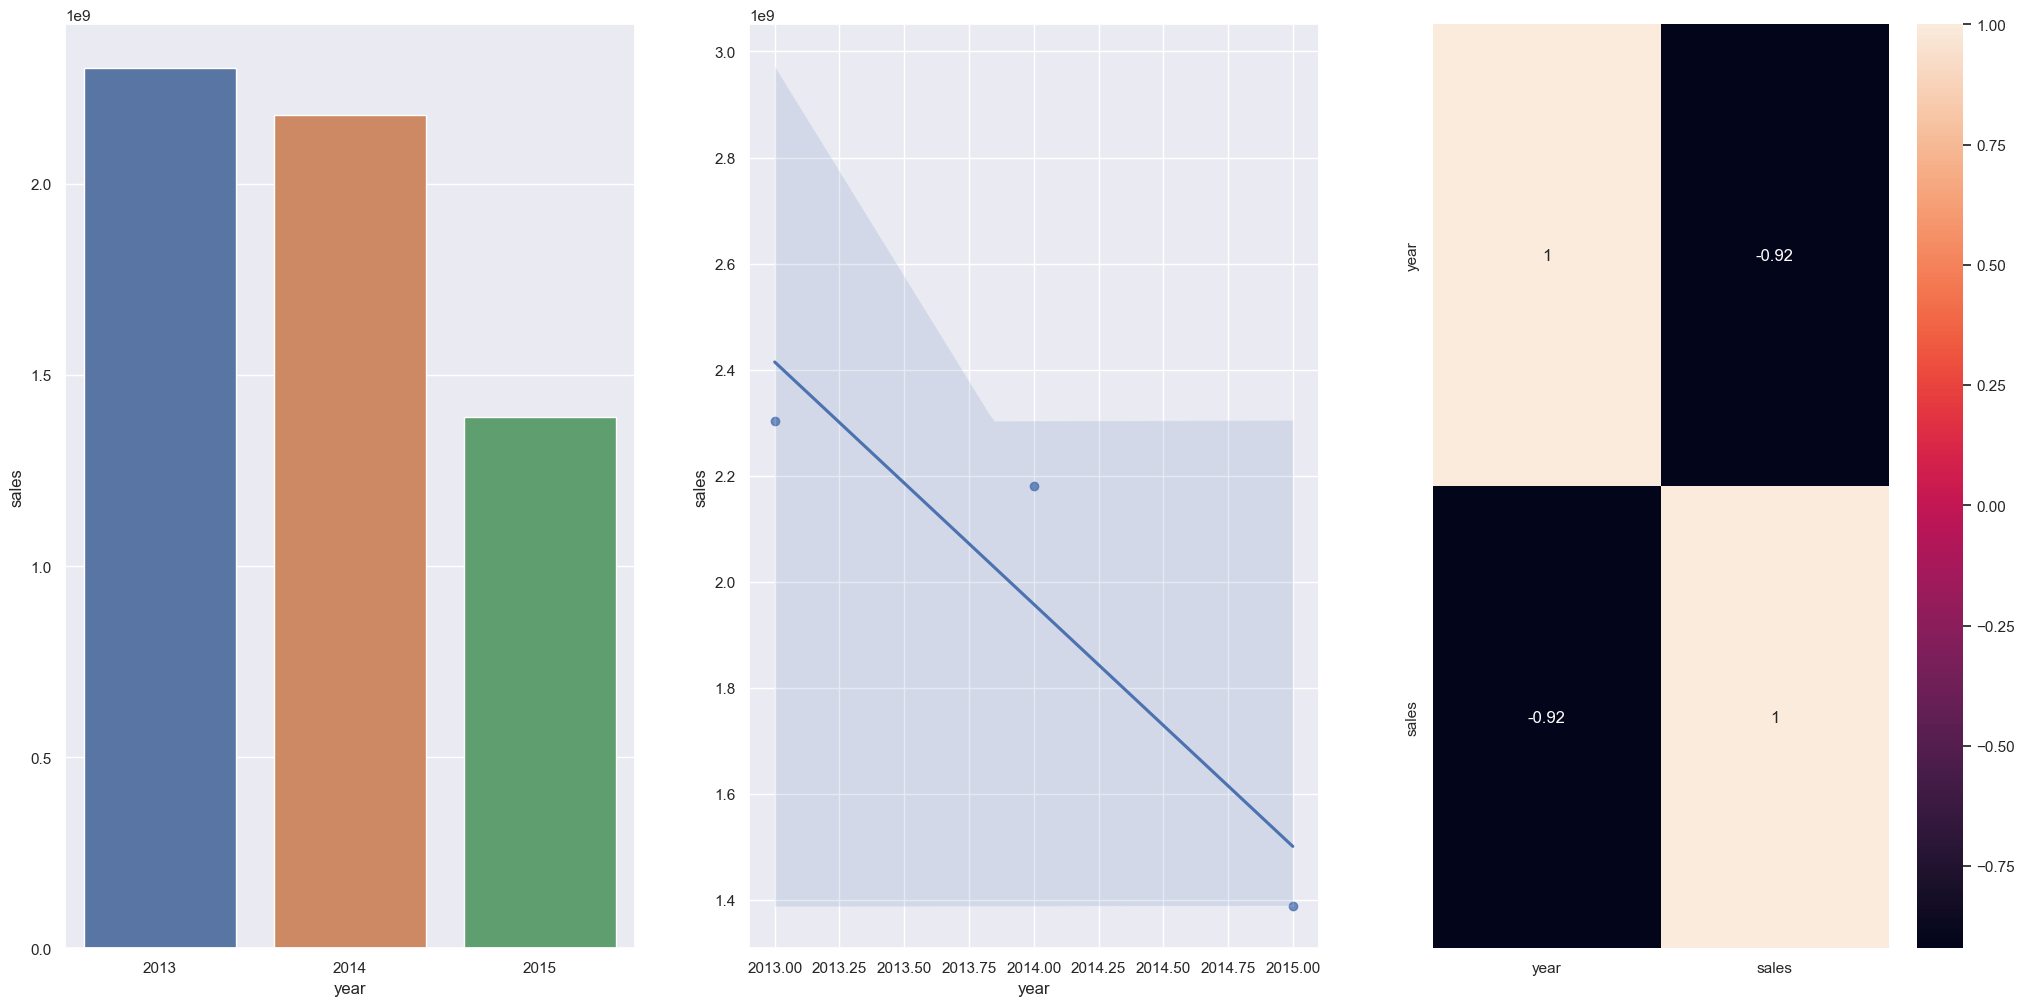

In [52]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(data=aux1, x='year', y='sales');

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='year', y='sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H9. Lojas deveriam vender mais no segundo semestre do ano.

**FALSA** Lojas tem tendencia de queda no segundo semestre

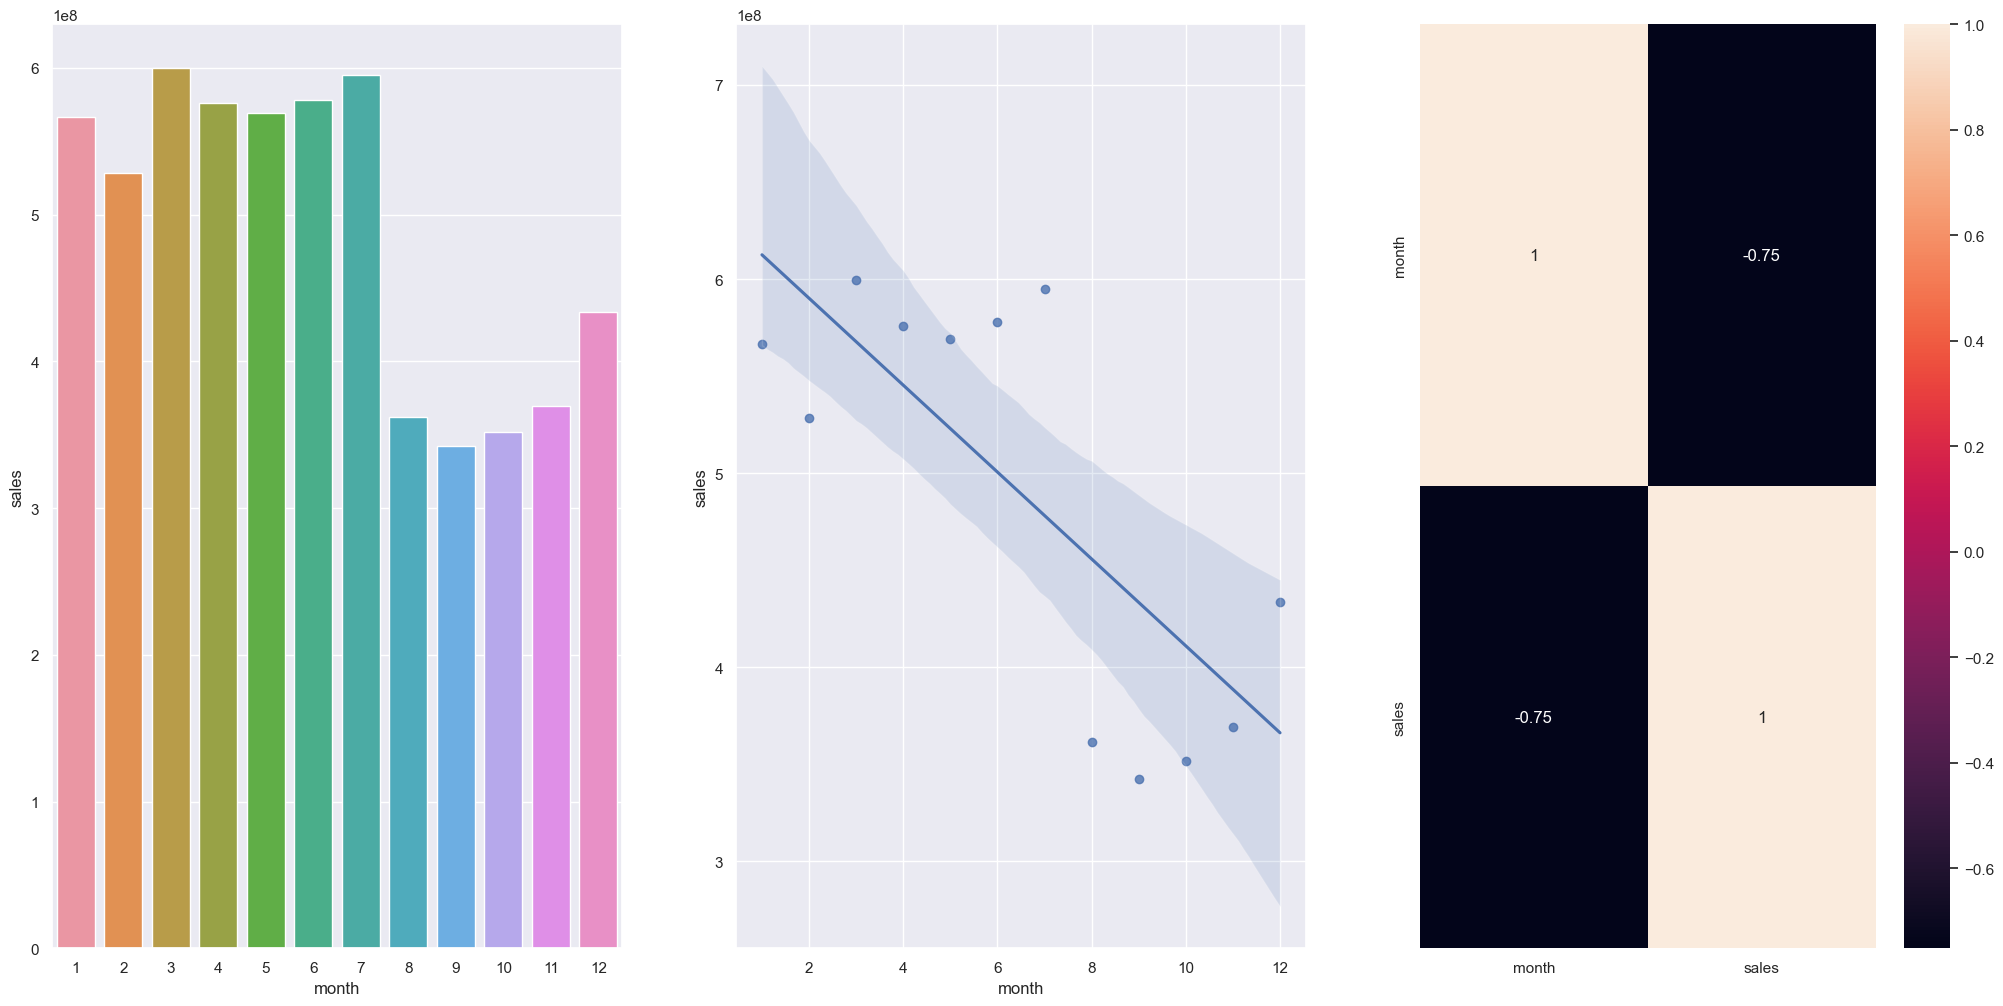

In [53]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(data=aux1, x='month', y='sales');

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='month', y='sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês

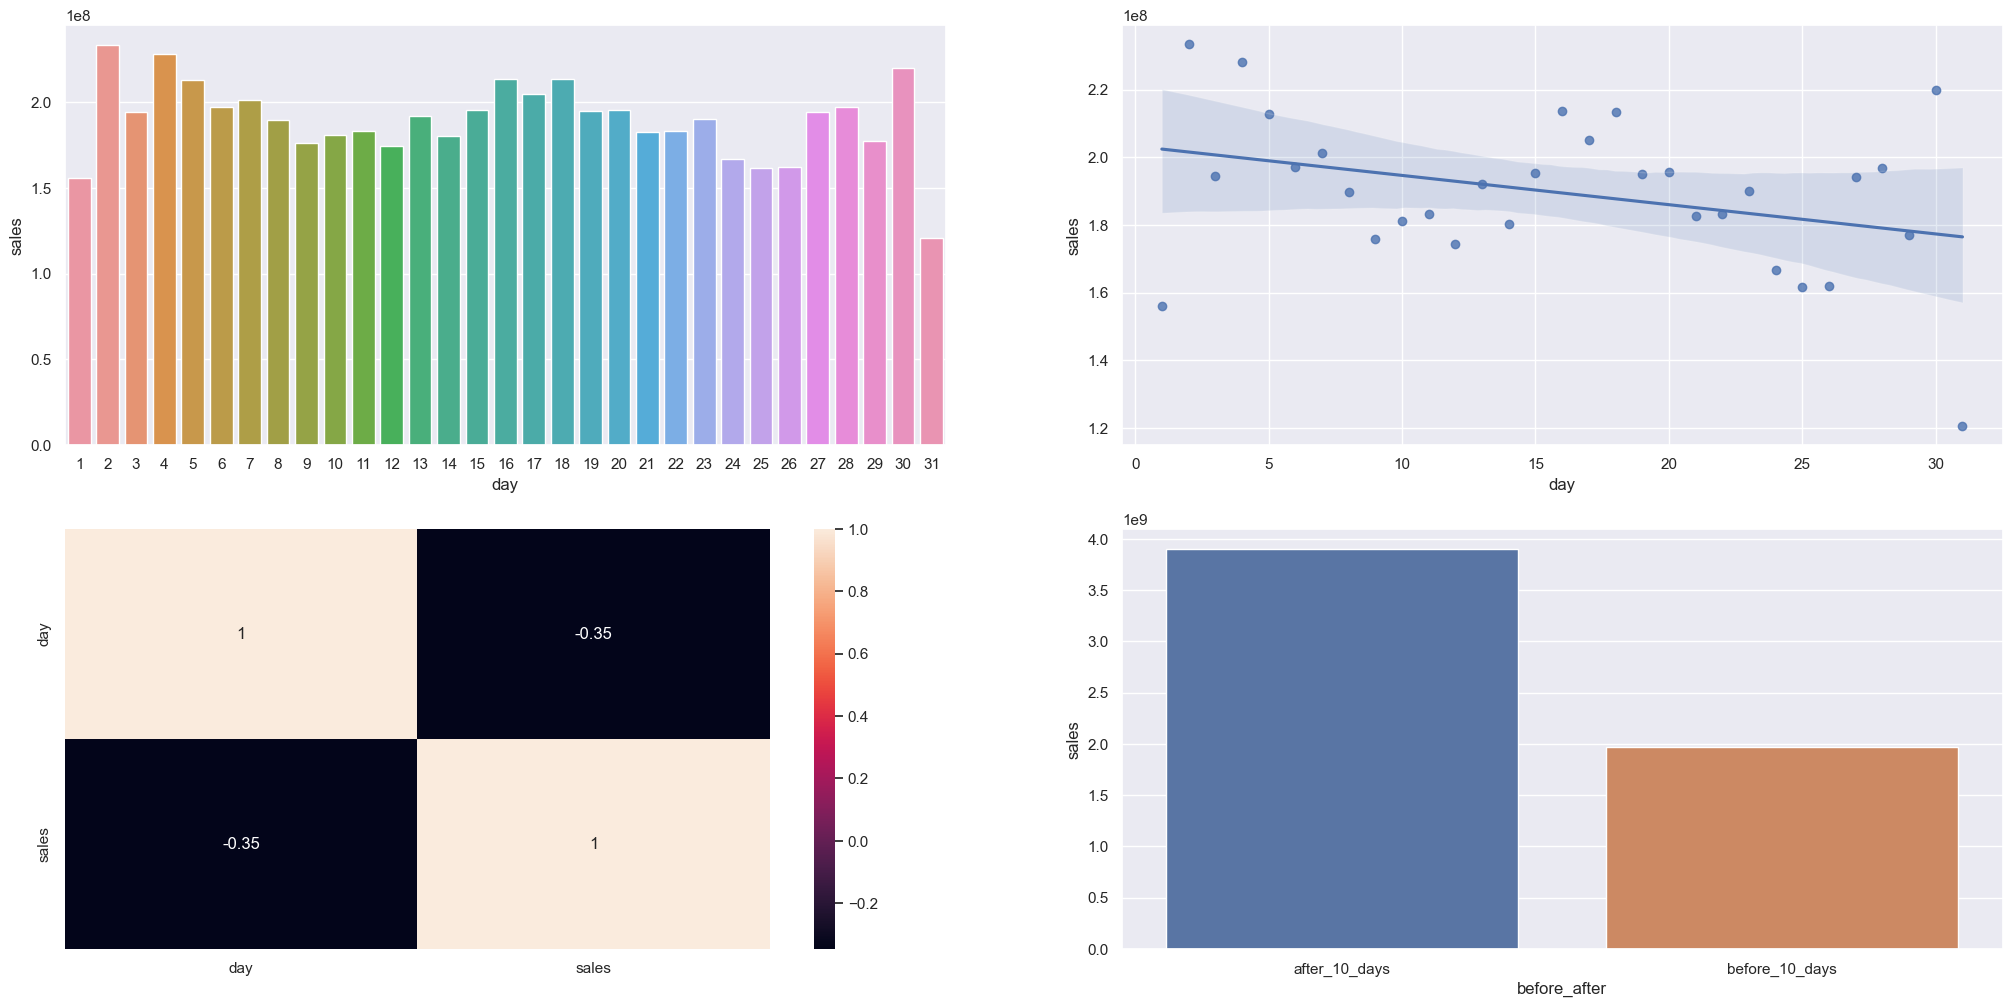

In [54]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(data=aux1, x='day', y='sales');

plt.subplot(2,2,2)
sns.regplot(data=aux1, x='day', y='sales');

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')

plt.subplot(2,2,4)
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(data=aux2, x='before_after', y='sales');

### H11. Lojas deveriam vender menos aos finais de semana.

**VERDADEIRA** Lojas vendem menos nos finais de semana.

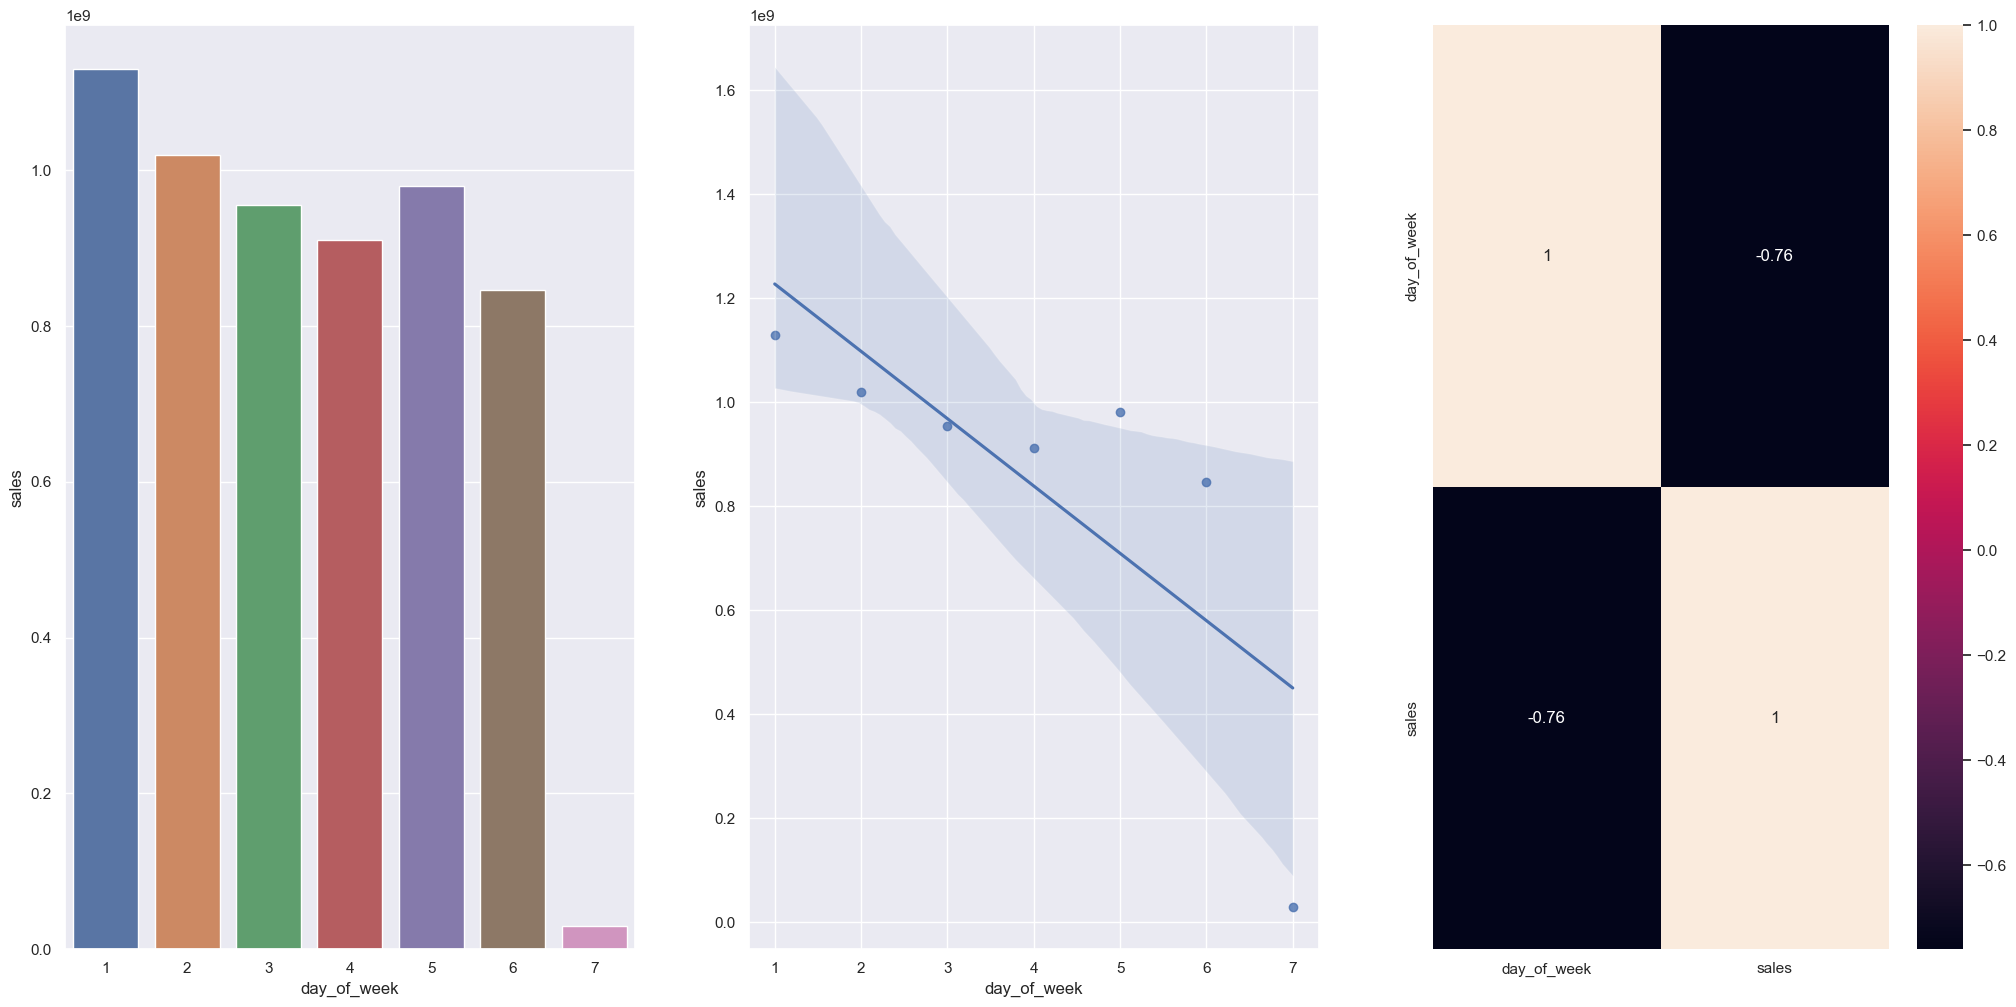

In [55]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(data=aux1, x='day_of_week', y='sales');

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='day_of_week', y='sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H12. Lojas deveriam vender menos durante os feriados escolares.

**VERDADEIRA** Lojas vendem menos durante os feriados escolares, porém nos meses de julho e agosto existe uma virada nas vendas

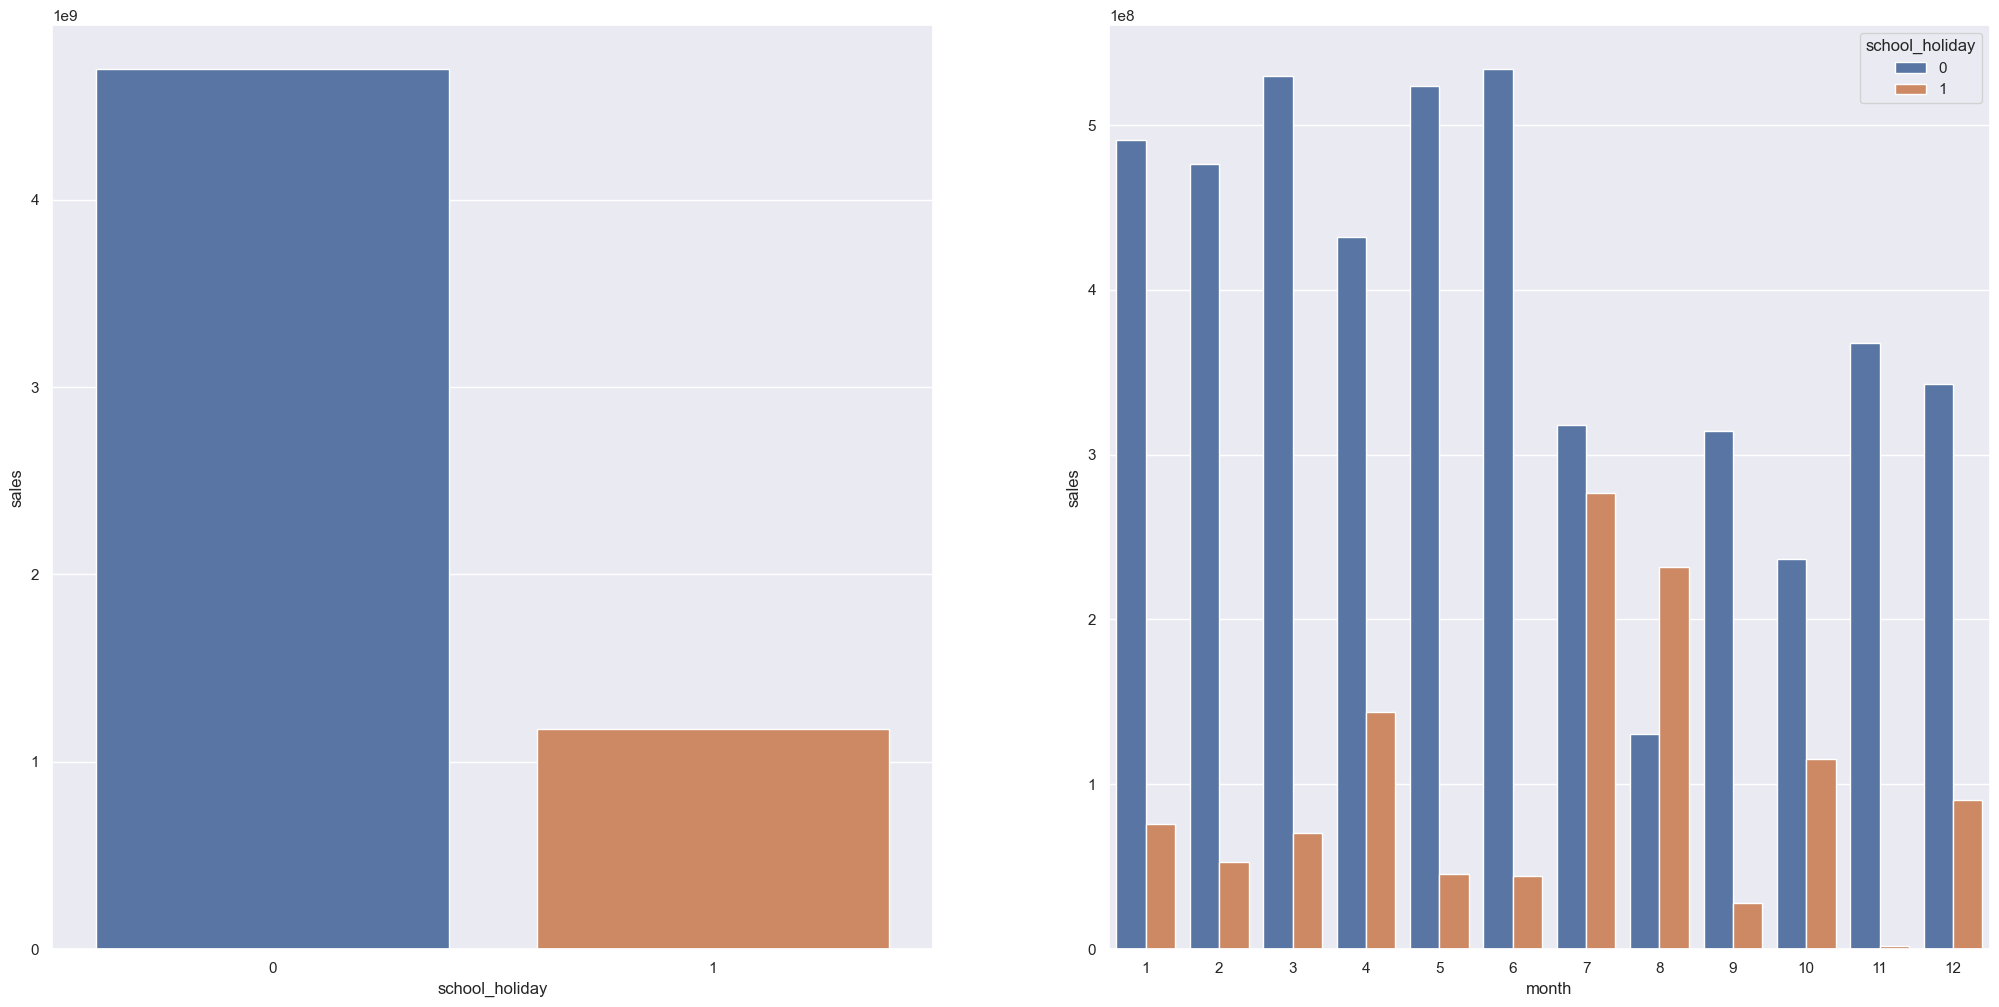

In [56]:
plt.subplot(1,2,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(data=aux1, x='school_holiday', y='sales');

plt.subplot(1,2,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(data=aux2, x='month', y='sales', hue='school_holiday');


### 4.2.1. Resumo das Hipóteses

In [57]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3. Análise Multivariada

In [58]:
# é feita para encontrar a relação entre variáveis, o que auxilia na decisão de manter ou excluir colunas.

### 4.3.1. Numerical Attributes

In [59]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


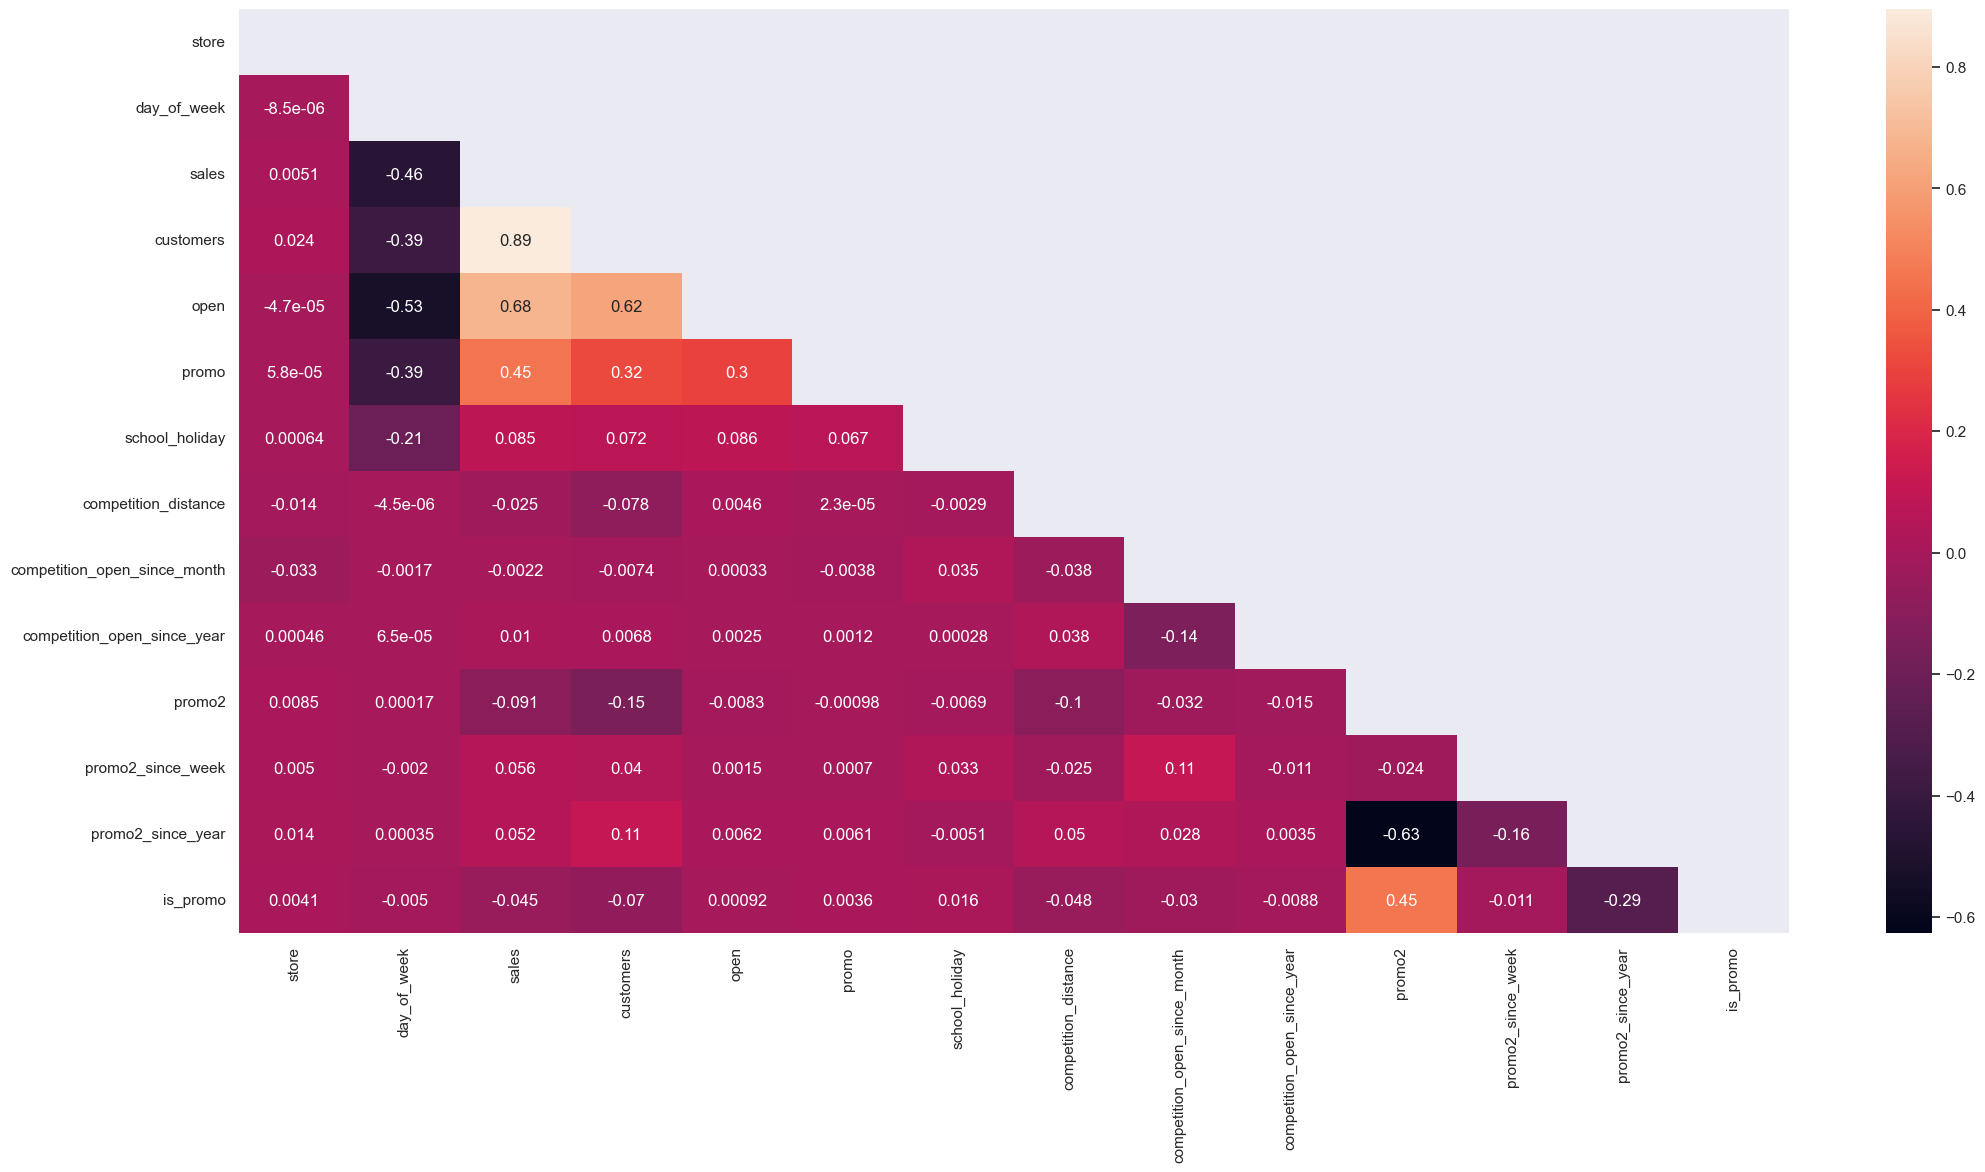

In [60]:
correlacao = num_attributes.corr(method='pearson')

mask = np.triu(np.ones_like(correlacao, dtype=bool)) #define a mascara, para não aparecer espelhado

sns.heatmap(correlacao, annot=True, mask=mask);

### 4.3.2. Categorical Attributes

In [61]:
##método de Pearson não funciona para variaveis categoricas, para isso precisa usar a V-Cramer # Para calcular Cramer-V - https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

# V-Cramer varia de 0 a 1 / não existe relação negativa (mais proximo de 0 menor a correlação)
# (FUNÇÃO DEFINIDA NA HELPER FUNCTION - PARA O CALCULO DO V-CRAMER PARA CADA CORRELAÇÃO)
#def cramer_v (x,y):
#    cm = pd.crosstab (x, y).values
#    n = cm.sum() #soma de todos os valores da matriz
#    r, k =cm.shape #número de linhas e colunas
#    
#    chi2 = ss.chi2_contingency(cm) [0] #método pronto para calculo de chi2 (precisa de uma tabela de contingencia (CM) para o calculo) / biblioteca scipy
#    chi2corr = max(0 , chi2 - (k-1)*(r-1)/(n-1))
#    
#    kcorr = k - (k-1)**2/(n-1)
#    rcorr = r - (r-1)**2/(n-1)
#   
#    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)))

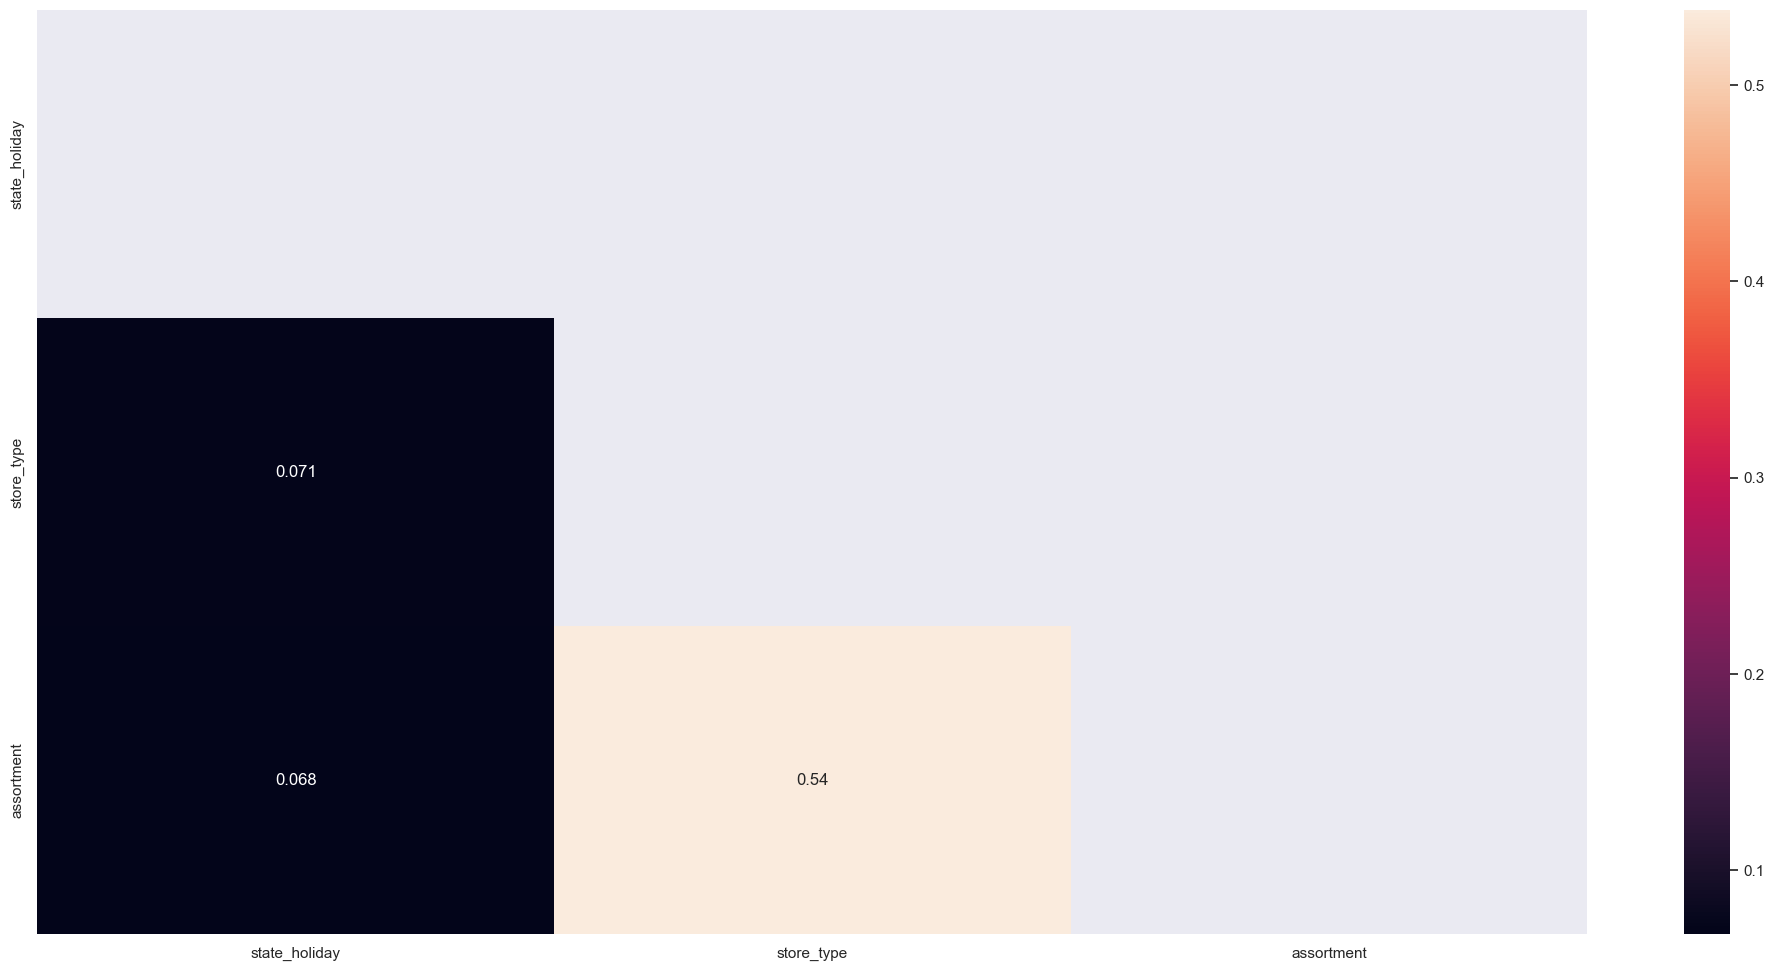

In [62]:
a = df4.select_dtypes( include='object') #SELECIONA SOMENTE VARIAVEIS CATEGORICAS

# CALCULA AS CORRELAÇÕES DE CRAMER ATRAVES DA FUNÇÃO PREDEFINIDA
a1 = cramer_v (a['state_holiday'], a['state_holiday']) 
a2 = cramer_v (a['state_holiday'], a['store_type'])
a3 = cramer_v (a['state_holiday'], a['assortment'])

a4 = cramer_v (a['store_type'], a['state_holiday'])
a5 = cramer_v (a['store_type'], a['store_type'])
a6 = cramer_v (a['store_type'], a['assortment'])

a7 = cramer_v (a['assortment'], a['state_holiday'])
a8 = cramer_v (a['assortment'], a['store_type'])
a9 = cramer_v (a['assortment'], a['assortment'])

d = pd.DataFrame ({ 'state_holiday': [a1,a2,a3],
                    'store_type': [a4,a5,a6],
                    'assortment': [a7,a8,a9] })

d = d.set_index(d.columns) # SUBSTITUI O INDEX PELOS NOMES DAS COLUNAS

mask = np.triu(np.ones_like(d, dtype=bool)) #define a mascara, para não aparecer espelhado
sns.heatmap(d, annot=True, mask=mask); #PLOTA O HEATMAP

In [63]:
#=========================================================
#      VERIFICAR (https://pypi.org/project/pycorr/) 
#=========================================================

# 5.0. PASSO 05: PREPARAÇÃO DOS DADOS

In [126]:
df5 = df4.copy()

## 5.1. Normalização

In [65]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [66]:
# com base na análise das variaveis numericas, feita no item 4.1.2., conclui-se que nenhuma das variaveis tem distribuição normal, por isso foi orientado que não seja forçada a normalização através de fórmula, para não alterar a distribuição. 

## 5.2. Rescaling

In [129]:
rs = RobustScaler()

# competition distance (possiu outlier)
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open( 'parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb'))


mms = MinMaxScaler()

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open( 'parameter/year_scaler.pkl', 'wb'))


# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open( 'parameter/promo_time_week_scaler.pkl', 'wb'))


## 5.3. Trasformação

### 5.3.1. Encoding

In [128]:
# state_holiday (indica um estado - em feriados o comportamento altera, então utiliza OneHotEncoding)
df5 = pd.get_dummies (df5, prefix=['state_holiday'], columns=['state_holiday']) #prefix - nome que vai na frente da coluna / columns - coluna onde será aplicada

#store_type - Label Encoding (não possui ordem)
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open( 'parameter/store_type_scaler.pkl', 'wb'))


#assortment - Ordinal Encoding (possui uma ordem)
    #cria um dicionário com a ordem desejada
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
    #faz a transformaçao aplicando map
df5['assortment'] = df5['assortment'].map(assortment_dict)


### 5.3.2. Transformação da Variavel Resposta

In [69]:
#transformação da variavel resposta para ficar mais proxima da distribuição normal
(df5['sales']) = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [70]:
# month
df5['month_sin'] = df5['month'].apply ( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) ) # aplica a função seno / 12 é o periodo ciclico - 12 meses do ano
df5['month_cos'] = df5['month'].apply ( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) ) # aplica a função cosseno / 12 é o periodo ciclico - 12 meses do ano

# day
df5['day_sin'] = df5['day'].apply ( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) ) # aplica a função seno / 30 é o periodo ciclico - média 30 dias no mês
df5['day_cos'] = df5['day'].apply ( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) ) # aplica a função cosseno / 30 é o periodo ciclico - média 30 dias no mês

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply ( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) ) # aplica a função seno / 52 é o periodo ciclico - 52 semanas no ano
df5['week_of_year_cos'] = df5['week_of_year'].apply ( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) ) # aplica a função cosseno / 52 é o periodo ciclico - 52 semanas no ano

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply ( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) ) # aplica a função seno / 7 é o periodo ciclico - 7 dias na semana
df5['day_of_week_cos'] = df5['day_of_week'].apply ( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) ) # aplica a função cosseno / 7 é o periodo ciclico - 7 dias na semana


# 6.0. PASSO 06: FEATURE SELECTION

In [71]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [72]:
#separa o dataset original em dois pedaços 


In [73]:
# é necessario deletar as variaveis que foram derivadas na transformação
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop (cols_drop, axis=1) # faz o drop do cols_drop na eixo y (coluna)

In [74]:
# separa em treino e teste (não pode separar aleatoriamente, uma vez que é um dataset temporal, porque pode overfitar o modelo - ele decora o padrão futuro e sempre vai acertar, dai não tem aprendizado, so "decoreba")
#definido o criterio de selecionar as ultimas seis semanas para teste e o restante sera o treino.

#df6 [['store', 'date']].groupby ('store').min().reset_index() ['date'] # Calculo do valor mínimo da data de venda, para saber onde começa o dataset
#df6 [['store', 'date']].groupby ('store').max().reset_index() ['date'] # Calculo do valor mínimo da data de venda, para saber onde termina o dataset e poder selecionar 6 semanas antes

df6 [['store', 'date']].groupby ('store').max().reset_index() ['date'] [0] - datetime.timedelta(days=6*7) #seleciona a ultima data do dataset e subtrai 52 dias (6*7)

Timestamp('2015-06-19 00:00:00')

In [75]:
# filtra para criação do dataset de treino e teste
#training dataset
X_train = df6[df6['date'] < '2015-06-19'] #todas as linhas e colunas do dataset filtrados
y_train = X_train['sales'] #sales de acordo com o filtro

#test dataset
X_test = df6[df6['date'] > '2015-06-19'] #todas as linhas e colunas do dataset filtrados
y_test = X_test['sales'] #sales de acordo com o filtro

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-20 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [76]:
# training e test dataset para o Boruta - precisa se vetor e não DF / não pode ter date e sales porque são variaveis de teste
X_train_n = X_train.drop( ['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor (n_jobs=-1) #paramentro para que faça as arvores em paralelo e rode mais rapido

#define o Boruta
#boruta = BorutaPy(rf,n_estimators='auto', verbose=2, random_state=42). fit(X_train_n, y_train_n)

### 6.2.1. Best Features from Boruta

In [77]:
#cols_selected = boruta.support_.tolist()  #valor do rang que o Boruta ranqueou de acordo com a relevância

#X_train_fs = X_train.drop( ['date', 'sales'], axis=1) # dropa date e sales do dataframe x_train
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list() #seleciona o index encontrado no Boruta para encontrar o nome da coluna

#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta)) #faz o comparativo do que tem no x_train e não foi selecionado pelo Boruta

In [78]:
#cols_selected_boruta

In [79]:
#cols_not_selected_boruta

## 6.3. Manual Feature Selection

In [80]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos',
                        'day_of_week_sin',
                        'day_of_week_cos']

# adicionando colunas date e sales
feat_to_add = ['date', 'sales' ]

# final feature
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [81]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# 7.0. PASSO 07: MACHINE LEARNING MODELING

In [82]:
# Como o RMSE do Avarege Model é menor, isso significa que modelos lineares não conseguem aprender, pelo fato do fenomeno ser pouco ou muito complexo. 

In [83]:
#seleciona somente as variaveis que o Boruta considerou relevante (tanto para treino quanto para teste)
x_train = X_train[cols_selected_boruta] 
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full] #para selecionar o dataset com a coluna date e sales

## 7.1. Average Model

In [84]:
#média de vendas de cada loja

aux1 = x_test.copy()
aux1 ['sales'] = y_test.copy() #insere a variavel sales (que estava em y_test, no dataset x_test)

#prediction
aux2 = aux1 [['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'}) #calcula média de vendas de todas as lojas, e faz a troca do nome da coluna sales 
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions'] #seleciona a estimativa do valor

#preformance
baseline_result = ml_error ('Average Model', np.expm1(y_test), np.expm1(yhat_baseline)) #y_test são as vendas reais e y_hat o valor estimado
#na transformação, a variavel resposta foi trasnformada por um log, e agora precisa voltar ao valor original, usando um exponencial atraves do np.expm1                                                                                                                    
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1366.128351,0.452087,1854.263316


## 7.2. Linear Regression Model

In [85]:
# model
lr = LinearRegression().fit(x_train, y_train) #definição que vai treinar o modelo - com os dados de treino

# prediction
yhat_lr = lr.predict (x_test) #faz a predição para a base de teste, com os dados que o modelo ainda não viu

# performance
lr_result = ml_error( 'LinearRegression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,LinearRegression,1868.73952,0.293745,2675.947846


### 7.2.1. Linear Regression Model - Cross Validation

In [86]:
lr_result_cv = cross_validation (x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model

In [87]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train) #definição que vai treinar o modelo - com os dados de treino #alpha é um fator multiplicativo, que pode aumentar ou diminuir o peso das variaveis, para que fiquem dentro do RANGE desejado, para ser comparavel

# prediction
yhat_lrr = lrr.predict (x_test) #faz a predição para a base de teste, com os dados que o modelo ainda não viu

# performance
lrr_result = ml_error( 'LinearRegression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,LinearRegression - Lasso,1894.132074,0.290168,2750.81867


### 7.3.1. Linear Regression Regularized Model - Cross Validation

In [88]:
lrr_result_cv = cross_validation (x_training, 5, 'Linear Regression - Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [89]:
# model
rf = RandomForestRegressor( n_estimators = 100, n_jobs=-1, random_state=42).fit(x_train, y_train) #definição que vai treinar o modelo - com os dados de treino #n_estimator = qtas arvores vai criar, n_jobs permite que rode em paralelo
# prediction
yhat_rf = rf.predict (x_test) #faz a predição para a base de teste, com os dados que o modelo ainda não viu

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.205111,0.100215,1013.636546


### 7.4.1. Random Forest Regressor - Cross Validation

In [90]:
rf_result_cv = cross_validation (x_training, 5, 'Random Forest Regressor', rf, verbose=False)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.97 +/- 218.4,0.12 +/- 0.02,1256.45 +/- 318.73


## 7.5. XGBoost Regressor

In [91]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6667.268118,0.949326,7320.284961


### 7.5.1. XGBoost Regressor - Cross Validation

In [92]:
xgb_result_cv = cross_validation (x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.26 +/- 588.66,0.95 +/- 0.0,7715.27 +/- 689.48


## 7.6. Compare Models Performance

### 7.6.1. Single Performance

In [93]:
modelling_result = pd.concat ([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.205111,0.100215,1013.636546
0,Average Model,1366.128351,0.452087,1854.263316
0,LinearRegression,1868.739520,0.293745,2675.947846
0,LinearRegression - Lasso,1894.132074,0.290168,2750.818670
0,XGBoost Regressor,6667.268118,0.949326,7320.284961


### 7.6.2. Real Performance - Crorr Validation

In [94]:
modelling_result_cv = pd.concat ( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Linear Regression - Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,837.97 +/- 218.4,0.12 +/- 0.02,1256.45 +/- 318.73
0,XGBoost Regressor,7049.26 +/- 588.66,0.95 +/- 0.0,7715.27 +/- 689.48


# 8.0. PASSO 08: HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [95]:
#param = {
#        'n_estimators': [1500, 1700, 2500, 3000, 3500],
#        'eta': [0.01, 0.03],
#        'max_depth': [3, 5, 9],        
#        'subsample': [0.1, 0.5, 0.7 ],        
#        'colsample_bytree': [0.3, 0.7, 0.9],        
#        'min_child_weight': [3, 8, 15] 
#        }                
#
#MAX_EVAL = 10

In [96]:
#final_result = pd.DataFrame()
#
#for i in range(MAX_EVAL):
#    #escolhe os valores dos parametros aleatoreamente
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print ( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], #lista com os valores que deseja testar
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#    
#    
#    # performance
#    result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False )
#    final_result = pd.concat ([final_result, result])
#    
#final_result

## 8.2. Final Model


In [97]:
param_tuned = {'n_estimators': 1500, 
               'eta': 0.03, 
               'max_depth': 9, 
               'subsample': 0.5, 
               'colsample_bytree': 0.9, 
               'min_child_weight': 15
              }      

MAX_EVAL = 5 

In [98]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit(x_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
result_xgb_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
result_xgb_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,637.80125,0.092958,938.592468


In [100]:
#calcula valor mínimo de y_test
np.expm1(y_test).min()

569.0000000000002

In [101]:
#calcula valor maximo de y_test
np.expm1(y_test).max()

41550.99999999998

In [102]:
#calcula a diferença na range
np.expm1(y_test).max()-np.expm1(y_test).min()

40981.99999999998

In [103]:
#calcula média de y_test
np.expm1(y_test).mean()

6978.638051735266

In [104]:
#calcula o mpe
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

0.0014576978689985582

# 9.0. PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [106]:
df9 = X_test[ cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1 (df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [113]:
# soma das predições
df91 = df9 [['store', 'predictions']].groupby ('store').sum().reset_index()

#MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x:mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x:mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

#Cenários
df92['pior_cenario'] = df92['predictions'] - df92['MAE']
df92['melhor_cenario'] = df92['predictions'] + df92['MAE']

#Ordenar as colunas
df92 = df92[['store', 'predictions', 'melhor_cenario', 'pior_cenario', 'MAE', 'MAPE']]

In [115]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,melhor_cenario,pior_cenario,MAE,MAPE
291,292,99171.078125,102669.659790,95672.496460,3498.581665,0.591419
908,909,223695.531250,231561.826527,215829.235973,7866.295277,0.530626
594,595,329667.562500,334774.769504,324560.355496,5107.207004,0.351019
875,876,194712.843750,198806.686213,190619.001287,4093.842463,0.312570
721,722,338026.656250,339852.702176,336200.610324,1826.045926,0.244263


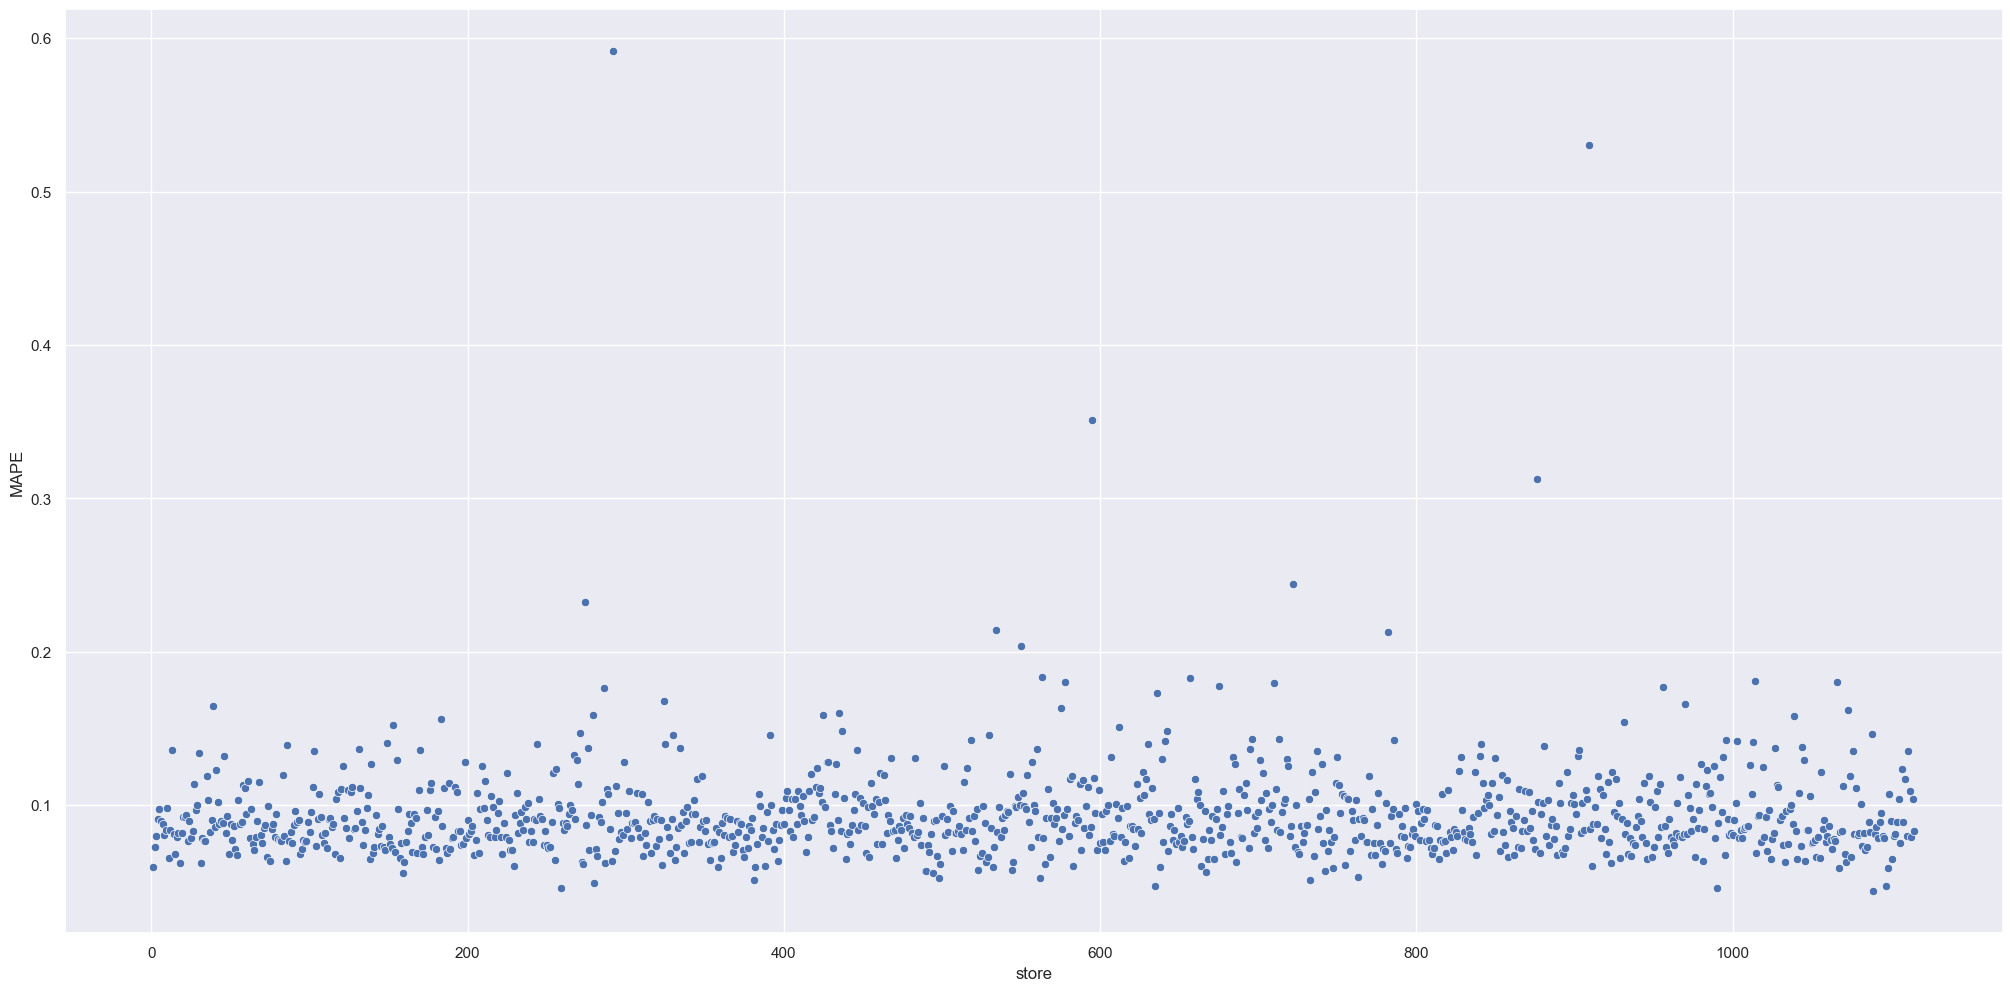

In [117]:
sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2. Total Performance

In [119]:
df93 = df92[['predictions', 'pior_cenario', 'melhor_cenario']].apply (lambda x: np.sum (x), axis=0).reset_index().rename(columns={'index':'cenario', 0:'valores'})
df93['valores'] = df93['valores'].map( 'R${:,.2f}'.format)
df93

,cenario,valores
0,predictions,"R$275,574,976.00"
1,pior_cenario,"R$274,859,482.87"
2,melhor_cenario,"R$276,290,457.29"


## 9.3. Machine Learning Performance

In [120]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

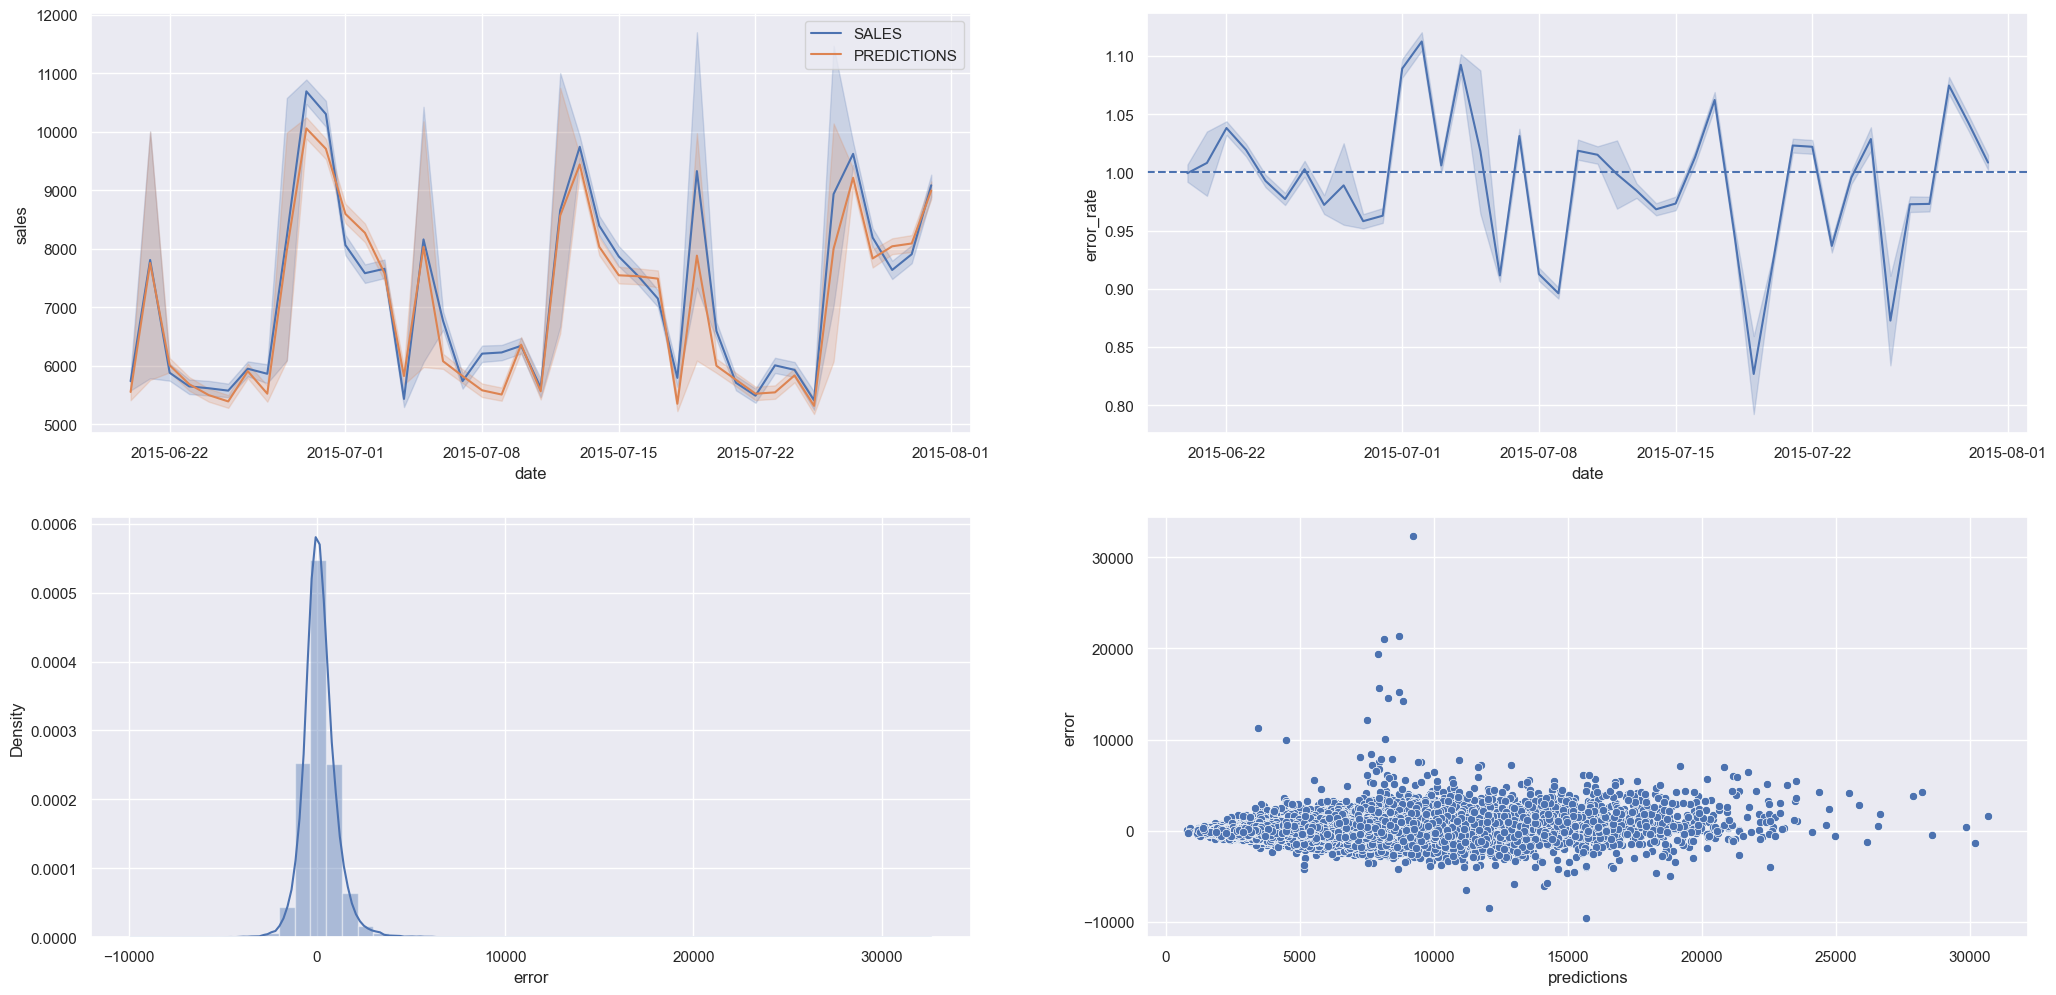

In [122]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES');
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS');

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle= '--'); #acima da linha um tem uma superestimação, e abaixo uma subestimação 

plt.subplot(2,2,3)
sns.distplot(df9['error']);

plt.subplot(2,2,4)
sns.scatterplot( df9['predictions'], df9['error']);

In [ ]:
##PROCURAR ANALISE DE RESIDUO##

# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [99]:
##SALVA O MODELO, PARA NÃO PRECISAR RODAR TODA VEZ##
pickle.dump( model_xgb_tuned, open('model/model_rossmann.pkl', 'wb'))

## 10.1. Rossmann Class

In [126]:
class Rossmann(object):
    def __init__(self):
        self.competition_distance_scaler   = pickle.load(open( 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open( 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open( 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open( 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open( 'parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self,df1):

        ## 1.1. Rename Columns
        old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']
        
        #define a função para transformar as strings
        lower_ = lambda x: x.lower() #transforma em letras minusculas
        snakecase = lambda x: inflection.underscore(x) #transforma em letra minuscula com separação por underscore
                
        #define a variavel, com a lista da aplicação da função map
        new_cols = list (map(snakecase,old_cols))

        #RENAME - substitui o nome das colunas pela new_cols
        df1.columns = new_cols
        
        ## 1.3. Data Types 
        # converte a coluna date para formato datetime
        df1['date'] = pd.to_datetime(df1['date'])

        
        ## 1.5. Fillout NA 
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)
        
        # competition_open_since_month  
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'])
                                                        else x['competition_open_since_month'], axis=1)
                                                  
        # competition_open_since_year - assumindo a data de venda      
        df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
                                                        else x['competition_open_since_year'], axis=1)
        
        # promo2_since_week  
        df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                                              else x['promo2_since_week'], axis=1)
        
        # promo2_since_year  
        df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
                                              else x['promo2_since_year'], axis=1)
        
        # promo_interval
        month_map = {1: 'Jan',  2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sept',  10: 'Oct', 11: 'Nov', 12: 'Dec'} # cria dicionário para substituir o numero do mês
        
        df1['promo_interval'].fillna(0, inplace=True )
        
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )
        
        
        ## 1.6. Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype ('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype ('int64')
        df1['promo2_since_week'] = df1['promo2_since_week'].astype ('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype ('int64')
        
        return df1
    
    def feature_engineering(self, df2):
        
        # year (coluna, transforma em datatime (dt) e usa o metodo .year)
        df2['year'] = df2['date'].dt.year
        
        # month
        df2['month'] = df2['date'].dt.month
        
        # day
        df2['day'] = df2['date'].dt.day
        
        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        df2['week_of_year'] = df2['week_of_year'].astype('int64')
        
        # year week
        df2['year_week'] = df2['date'].dt.strftime ('%Y-%W')
        
        #competition since
        #cria coluna competition_since, fazendo a união atravez do método datetime.datetime
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        #faz a diferença das colunas date e competition_since - para obter o tempo de promoção em mes
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
        df2['competition_time_month'] = df2['competition_time_month'].astype('int64')
        
        
        # promo since
        #faz a conversão em str, e a união das colunas promo2_since_year e promo_since_week, para formação da coluna promo_since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        #faz a formatação e granularidade da coluna
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' )-datetime.timedelta( days=7 ) )
        #faz a diferença 
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )
        df2['promo_time_week'] = df2['promo_time_week'].astype('int64')
        
        # assortment 
        #faz a substituição das letras pelo seu significado
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        
        # state holiday
        #faz a substituição pelos significados
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')
        
        
        ## 3.1. Filtragem das Linhas
        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]
        
        ## 3.2. Seleção das Colunas
        #define as colunas 'irrelevantes' para o modelo, neste momento. (Customers não estará disponível no momento da aplicação do modelo.)
        cols = ['customers' , 'open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols, axis=1)
    
        return df2

    def data_preparation( self, df5 ):
              
        ## 5.2. Rescaling
        # competition distance (possiu outlier)
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)
        
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)
        
        # year
        df5['year'] = self.year_scaler.transform(df5[['year']].values)
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)
             
        ### 5.3.1. Encoding
        
        # state_holiday (indica um estado - em feriados o comportamento altera, então utiliza OneHotEncoding)
        df5 = pd.get_dummies (df5, prefix=['state_holiday'], columns=['state_holiday']) #prefix - nome que vai na frente da coluna / columns - coluna onde será aplicada
        
        #store_type - Label Encoding (não possui ordem)
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])
    
        #assortment - Ordinal Encoding (possui uma ordem)
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        
        ### 5.3.3. Nature Transformation
        # month
        df5['month_sin'] = df5['month'].apply ( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) ) # aplica a função seno / 12 é o periodo ciclico - 12 meses do ano
        df5['month_cos'] = df5['month'].apply ( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) ) # aplica a função cosseno / 12 é o periodo ciclico - 12 meses do ano
        
        # day
        df5['day_sin'] = df5['day'].apply ( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) ) # aplica a função seno / 30 é o periodo ciclico - média 30 dias no mês
        df5['day_cos'] = df5['day'].apply ( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) ) # aplica a função cosseno / 30 é o periodo ciclico - média 30 dias no mês
        
        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply ( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) ) # aplica a função seno / 52 é o periodo ciclico - 52 semanas no ano
        df5['week_of_year_cos'] = df5['week_of_year'].apply ( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) ) # aplica a função cosseno / 52 é o periodo ciclico - 52 semanas no ano
        
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply ( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) ) # aplica a função seno / 7 é o periodo ciclico - 7 dias na semana
        df5['day_of_week_cos'] = df5['day_of_week'].apply ( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) ) # aplica a função cosseno / 7 é o periodo ciclico - 7 dias na semana
        
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2',                                                       'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',                                           'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']

        
        return df5[cols_selected]


## 10.2. API Handler

In [ ]:
import pandas as pd
import pickle
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

#load model
model = pickle.load( open('\Users\ivero\OneDrive\comunidade_ds\repos\ds_em_producao\model\model_rossmann.pkl', 'rb'))

#inicializa API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST']) #endpoint
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:#se tiver dado
        if isinstance(test_jason, dict): #unico dado
            test_raw = pd.DataFrame( test_json, index=[0])
        
        else: # multiplos dados
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys())
    
    else:
        return Response ( '{}', status=200, mimetype='application/json')

    # Instancia Rossmann_class
    pipeline = Rossmann()
    
    #data cleaning
    df1 = pipeline.data_cleaning(test_raw)
    
    #feature engineering
    df2 = pipeline.feature_engineering(df1)
    
    #data preparation
    df3 = pipeline.data_preparation(df2)
    
    #prediction
    df_response = pipeline.get_prediction(model,test_raw,df3)
    
    return df_response
    
if __name__ == '__main__':
    app.run( '0.0.0.0')

## 10.3. API Tester